In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
%matplotlib inline
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)
from wordcloud import WordCloud

### Getting Data
##### Getting Data From Csv's

In [2]:
cards_data = pd.read_csv('datasets/cards_data.csv')
users_data = pd.read_csv('datasets/users_data.csv')

##### Getting Data From Json's

In [3]:
#  path = kagglehub.dataset_download("computingvictor/transactions-fraud-datasets")
#  print("Path to dataset files:", path)
# with open(path+'/train_fraud_labels.json','r') as fraud_label:
#     target = json.load(fraud_label)

In [4]:
with open('datasets/mcc_codes.json','r') as mcc_codes:
    data = json.load(mcc_codes)
with open('datasets/train_fraud_labels.json','r') as fraud_label:
    target = json.load(fraud_label)

In [5]:
mcc_codes = pd.DataFrame(list(data.items()), columns=['mcc', 'Description'])
fraud_label_target = pd.DataFrame(list(target.get('target').items()), columns=['transaction_id', 'fraud'])

##### Getting Data from Database

In [6]:
from db_connection import connect_to_db
connection = connect_to_db()
query = "SELECT * FROM transaction"
transaction_data = pd.read_sql(query, connection)

### IDA and Pre-processing

In [7]:
def get_data_card(df):
    print(f"Shape of given data is {df.shape}")
    print (f"\nCount of duplicate values is {df.duplicated().sum()}")
    print("\nNull Values ===> \n")
    print(df.isna().sum())
    print ("\nInformation about Data ===> \n")
    print(df.info())

##### Cards

In [8]:
cards_data.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [9]:
get_data_card(cards_data)

Shape of given data is (6146, 13)

Count of duplicate values is 0

Null Values ===> 

id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
dtype: int64

Information about Data ===> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     6146 non-null   int64 
 1   client_id              6146 non-null   int64 
 2   card_brand             6146 non-null   object
 3   card_type              6146 non-null   object
 4   card_number            6146 non-null   int64 
 5   expires                6146 non-null   object
 6  

In [10]:
cards_data['credit_limit'] = cards_data['credit_limit'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)

In [11]:
cards_data.card_on_dark_web.value_counts()

card_on_dark_web
No    6146
Name: count, dtype: int64

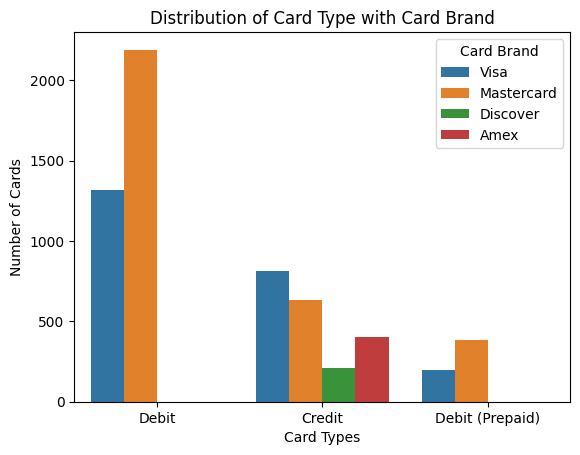

In [12]:
sns.countplot(x='card_type', hue='card_brand', data=cards_data)
plt.title("Distribution of Card Type with Card Brand")
plt.xlabel("Card Types")
plt.ylabel("Number of Cards")
plt.legend(title="Card Brand")
plt.show()

Mastercard leads in total debit card issuance, while Visa shows a balanced distribution across all card types. Amex and Discover only issue credit cards, with no presence in debit or prepaid cards.

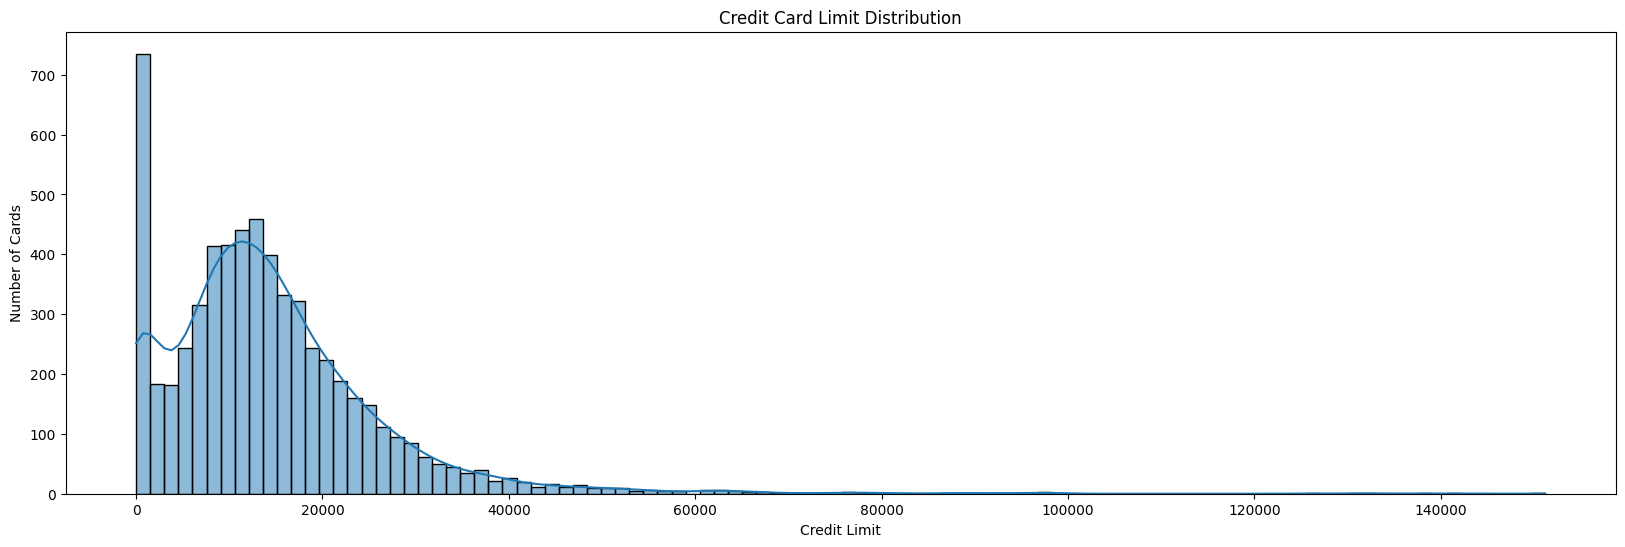

In [13]:
plt.figure(figsize=(20,6))
sns.histplot(data=cards_data, x='credit_limit', bins=100, kde=True)
plt.title("Credit Card Limit Distribution")
plt.xlabel("Credit Limit")
plt.ylabel("Number of Cards")
plt.show()

Most credit card limits fall between $10,000–$15,000, with many near zero and a few very high limits, showing a right-skewed distribution.

##### Users

In [14]:
users_data.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


In [15]:
get_data_card(users_data)

Shape of given data is (2000, 14)

Count of duplicate values is 0

Null Values ===> 

id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64

Information about Data ===> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   object 
 6   address            2000 non-null   object 
 7   lati

In [16]:
users_data['per_capita_income'] = users_data['per_capita_income'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)
users_data['yearly_income'] = users_data['yearly_income'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)
users_data['total_debt'] = users_data['total_debt'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)

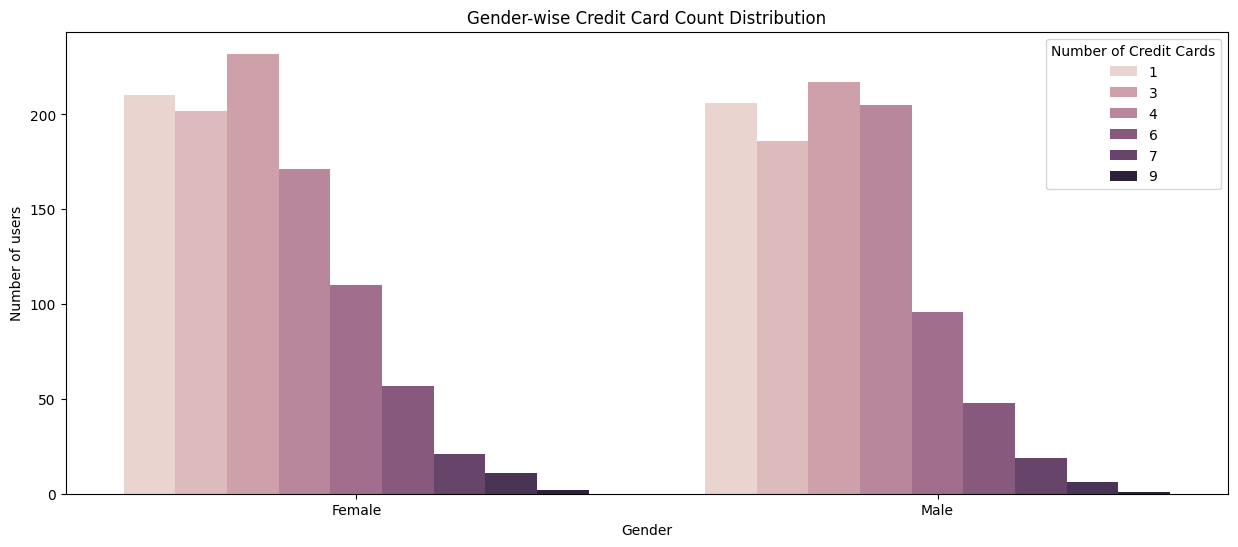

In [17]:
plt.figure(figsize=(15,6))
sns.countplot(x='gender', hue='num_credit_cards', data=users_data)
plt.title("Gender-wise Credit Card Count Distribution")
plt.xlabel("Gender")
plt.ylabel("Number of users")
plt.legend(title = "Number of Credit Cards")
plt.show()

Most People have 3 to 4 credit cards.

##### MCC Codes

In [18]:
mcc_codes.head()

,mcc,Description
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees


In [19]:
get_data_card(mcc_codes)

Shape of given data is (109, 2)

Count of duplicate values is 0

Null Values ===> 

mcc            0
Description    0
dtype: int64

Information about Data ===> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   mcc          109 non-null    object
 1   Description  109 non-null    object
dtypes: object(2)
memory usage: 1.8+ KB
None


In [20]:
mcc_codes.mcc  = mcc_codes.mcc.astype(int)

##### Fraud Labels

In [21]:
fraud_label_target.head()

,transaction_id,fraud
0,10649266,No
1,23410063,No
2,9316588,No
3,12478022,No
4,9558530,No


In [22]:
get_data_card(fraud_label_target)

Shape of given data is (8914963, 2)

Count of duplicate values is 0

Null Values ===> 

transaction_id    0
fraud             0
dtype: int64

Information about Data ===> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   transaction_id  object
 1   fraud           object
dtypes: object(2)
memory usage: 136.0+ MB
None


In [23]:
fraud_label_target.transaction_id  = fraud_label_target.transaction_id.astype(int)
fraud_label_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   transaction_id  int64 
 1   fraud           object
dtypes: int64(1), object(1)
memory usage: 136.0+ MB


In [24]:
fraud_label_target.fraud.value_counts()

fraud
No     8901631
Yes      13332
Name: count, dtype: int64

##### Transaction Data

In [25]:
transaction_data.head()

,id,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None


In [26]:
get_data_card(transaction_data)

Shape of given data is (13305915, 12)

Count of duplicate values is 0

Null Values ===> 

id                         0
date                       0
client_id                  0
card_id                    0
amount                     0
transaction_mode           0
merchant_id                0
merchant_city              0
merchant_state       1563700
zip                  1652706
mcc                        0
error               13094522
dtype: int64

Information about Data ===> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                int64  
 1   date              object 
 2   client_id         int64  
 3   card_id           int64  
 4   amount            float64
 5   transaction_mode  object 
 6   merchant_id       int64  
 7   merchant_city     object 
 8   merchant_state    object 
 9   zip               object 
 10  mcc               int64  


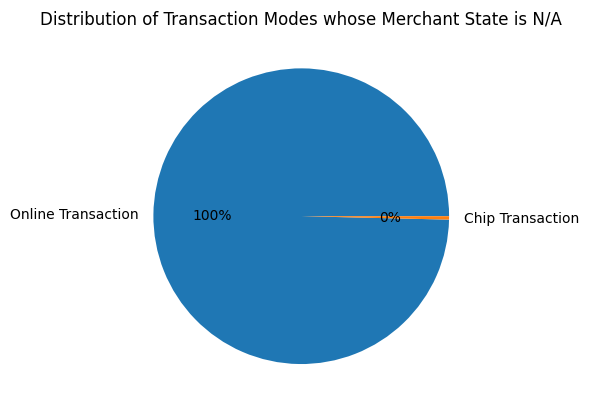

In [27]:
#All the transaction where merchant state is null are online Transactions

labels = transaction_data[transaction_data.merchant_state.isna()].transaction_mode.value_counts().index.tolist()
data = transaction_data[transaction_data.merchant_state.isna()].transaction_mode.value_counts().values
palette_color = sns.color_palette('tab10')
plt.pie(data, labels=labels, colors=palette_color, autopct='%.0f%%')
plt.title("Distribution of Transaction Modes whose Merchant State is N/A")
# displaying chart
plt.show()

In [28]:
transaction_data.date = pd.to_datetime(transaction_data.date)
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                int64         
 1   date              datetime64[ns]
 2   client_id         int64         
 3   card_id           int64         
 4   amount            float64       
 5   transaction_mode  object        
 6   merchant_id       int64         
 7   merchant_city     object        
 8   merchant_state    object        
 9   zip               object        
 10  mcc               int64         
 11  error             object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 1.2+ GB


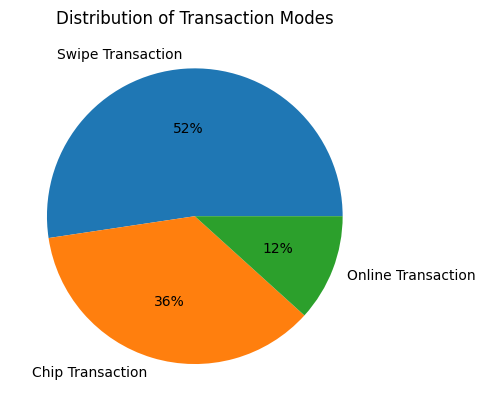

In [29]:
labels = transaction_data.transaction_mode.value_counts().index.tolist()
data = transaction_data.transaction_mode.value_counts().values
palette_color = sns.color_palette('tab10')
plt.pie(data, labels=labels, colors=palette_color, autopct='%.0f%%')
plt.title("Distribution of Transaction Modes")
# displaying chart
plt.show()

Swipe transactions dominate at 52%, followed by chip (36%) and online (12%) transactions.

### Merging DataFrames

In [30]:
transaction_fraud = transaction_data.merge(fraud_label_target,how='left',left_on='id', right_on='transaction_id')
transaction_fraud.drop('id',inplace=True,axis =1)

In [31]:
transaction_fraud_card = transaction_fraud.merge(cards_data[['id','card_brand','card_type','expires','has_chip','num_cards_issued','credit_limit','acct_open_date','year_pin_last_changed']],how='left',left_on='card_id', right_on='id')
transaction_fraud_card.drop('id',inplace=True,axis =1)

In [32]:
transaction_fraud_card_users = transaction_fraud_card.merge(users_data[['id','current_age','retirement_age','birth_year','birth_month','gender','per_capita_income','yearly_income','total_debt','credit_score','num_credit_cards']],how='left',left_on='client_id', right_on='id')
transaction_fraud_card_users.drop('id',inplace=True,axis =1)

In [33]:
main_df =  transaction_fraud_card_users.merge(mcc_codes,how='left',left_on='mcc',right_on='mcc')
main_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,transaction_id,fraud,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_year,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,Description
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,7475327.0,No,Mastercard,Debit (Prepaid),07/2022,YES,2,55.0,05/2008,2008,30,67,1989,7,Female,23679.0,48277.0,110153.0,740,4,Miscellaneous Food Stores
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,7475328.0,No,Mastercard,Credit,12/2024,YES,1,9100.0,09/2005,2015,48,67,1971,6,Male,18076.0,36853.0,112139.0,834,5,Department Stores
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,7475329.0,No,Mastercard,Debit,05/2020,YES,1,14802.0,01/2006,2008,49,65,1970,4,Male,16894.0,34449.0,36540.0,686,3,Money Transfer
3,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None,NaN,NaN,Mastercard,Debit,10/2024,NO,2,37634.0,05/2004,2006,52,67,1967,5,Female,26168.0,53350.0,128676.0,685,5,Money Transfer
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,7475332.0,No,Visa,Debit,01/2020,YES,1,19113.0,07/2009,2014,51,69,1968,5,Male,33529.0,68362.0,96182.0,711,2,Drinking Places (Alcoholic Beverages)


In [34]:
main_df.fraud.isna().sum()

np.int64(4390952)

In [35]:
main_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,transaction_id,fraud,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_year,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,Description
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,7475327.0,No,Mastercard,Debit (Prepaid),07/2022,YES,2,55.0,05/2008,2008,30,67,1989,7,Female,23679.0,48277.0,110153.0,740,4,Miscellaneous Food Stores
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,7475328.0,No,Mastercard,Credit,12/2024,YES,1,9100.0,09/2005,2015,48,67,1971,6,Male,18076.0,36853.0,112139.0,834,5,Department Stores
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,7475329.0,No,Mastercard,Debit,05/2020,YES,1,14802.0,01/2006,2008,49,65,1970,4,Male,16894.0,34449.0,36540.0,686,3,Money Transfer
3,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None,NaN,NaN,Mastercard,Debit,10/2024,NO,2,37634.0,05/2004,2006,52,67,1967,5,Female,26168.0,53350.0,128676.0,685,5,Money Transfer
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,7475332.0,No,Visa,Debit,01/2020,YES,1,19113.0,07/2009,2014,51,69,1968,5,Male,33529.0,68362.0,96182.0,711,2,Drinking Places (Alcoholic Beverages)


In [36]:
main_df['year'] = pd.to_datetime(main_df['date']).dt.year
main_df['month'] = pd.to_datetime(main_df['date']).dt.month

In [37]:
test_df = main_df[main_df.fraud.isna()]
final_df = main_df[main_df.fraud.notna()]
final_df = final_df[~final_df.year.isin([2014, 2011,2017])]

### Fraud Transaction Analysis

In [38]:
transaction_fraud_yes = final_df[final_df.fraud=='Yes']
final_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,transaction_id,fraud,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_year,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,Description,year,month
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,7475327.0,No,Mastercard,Debit (Prepaid),07/2022,YES,2,55.0,05/2008,2008,30,67,1989,7,Female,23679.0,48277.0,110153.0,740,4,Miscellaneous Food Stores,2010,1
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,7475328.0,No,Mastercard,Credit,12/2024,YES,1,9100.0,09/2005,2015,48,67,1971,6,Male,18076.0,36853.0,112139.0,834,5,Department Stores,2010,1
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,7475329.0,No,Mastercard,Debit,05/2020,YES,1,14802.0,01/2006,2008,49,65,1970,4,Male,16894.0,34449.0,36540.0,686,3,Money Transfer,2010,1
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,7475332.0,No,Visa,Debit,01/2020,YES,1,19113.0,07/2009,2014,51,69,1968,5,Male,33529.0,68362.0,96182.0,711,2,Drinking Places (Alcoholic Beverages),2010,1
5,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464,5942,None,7475333.0,No,Mastercard,Debit (Prepaid),03/2014,YES,1,89.0,01/2008,2015,47,65,1972,12,Female,25537.0,52065.0,98613.0,828,5,Book Stores,2010,1


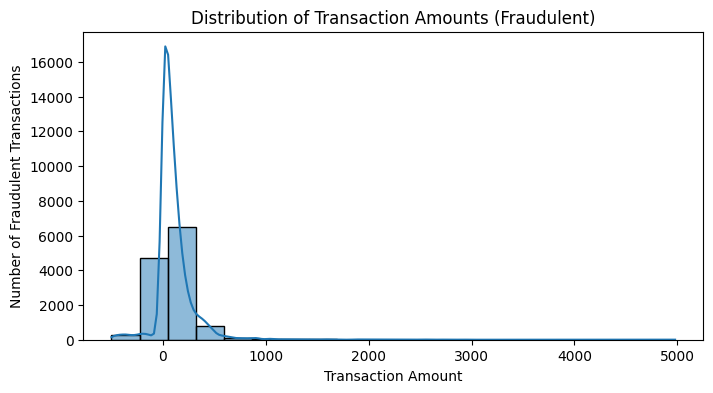

In [39]:
plt.figure(figsize=(8,4))
sns.histplot(data=transaction_fraud_yes, x='amount', bins=20, kde=True)
plt.title("Distribution of Transaction Amounts (Fraudulent)")
plt.xlabel("Transaction Amount")
plt.ylabel("Number of Fraudulent Transactions")
plt.show()

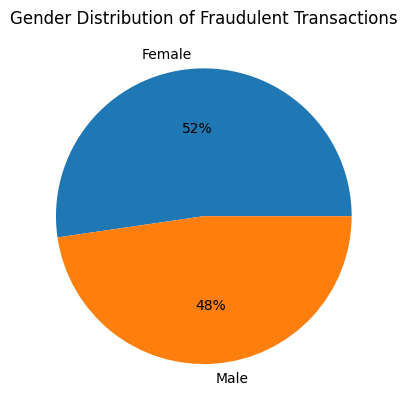

In [40]:
labels = transaction_fraud_yes.gender.value_counts().index.tolist()
data = transaction_fraud_yes.gender.value_counts().values
palette_color = sns.color_palette('tab10')
plt.pie(data, labels=labels, colors=palette_color, autopct='%.0f%%')
plt.title('Gender Distribution of Fraudulent Transactions')
# displaying chart
plt.show()

Fraud cases are nearly evenly split, with 52% involving females and 48% involving males.

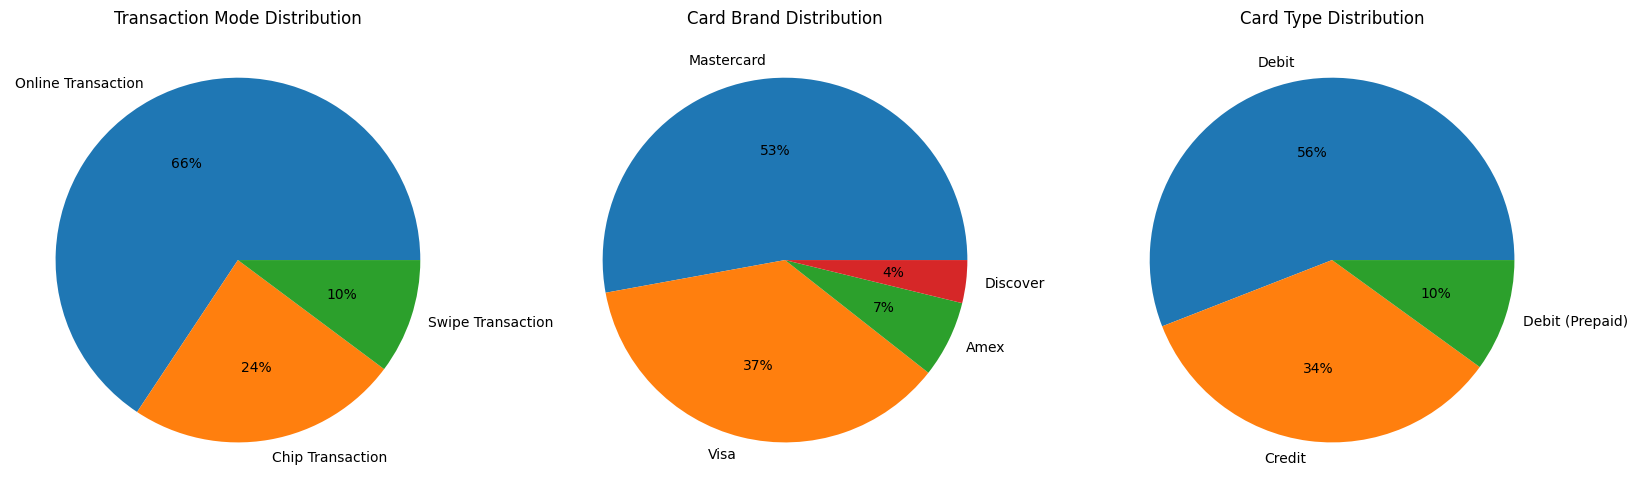

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

labels = transaction_fraud_yes.transaction_mode.value_counts().index.tolist()
data = transaction_fraud_yes.transaction_mode.value_counts().values
palette_color = sns.color_palette('tab10')
ax[0].pie(data, labels=labels, colors=palette_color, autopct='%.0f%%')
ax[0].set_title('Transaction Mode Distribution')


labels = transaction_fraud_yes.card_brand.value_counts().index.tolist()
data = transaction_fraud_yes.card_brand.value_counts().values
ax[1].pie(data, labels=labels, colors=palette_color, autopct='%.0f%%')
ax[1].set_title('Card Brand Distribution')


labels = transaction_fraud_yes.card_type.value_counts().index.tolist()
data = transaction_fraud_yes.card_type.value_counts().values
ax[2].pie(data, labels=labels, colors=palette_color, autopct='%.0f%%')
ax[2].set_title('Card Type Distribution')

plt.show()


1. Transaction Mode: Online transactions are the dominant mode, accounting for two-thirds of all transactions.
2. Card Brand: Mastercard and Visa together represent the vast majority of card usage, with Mastercard being slightly more prevalent.
3. Card Type: Debit cards are the most common card type used, significantly outnumbering credit cards.

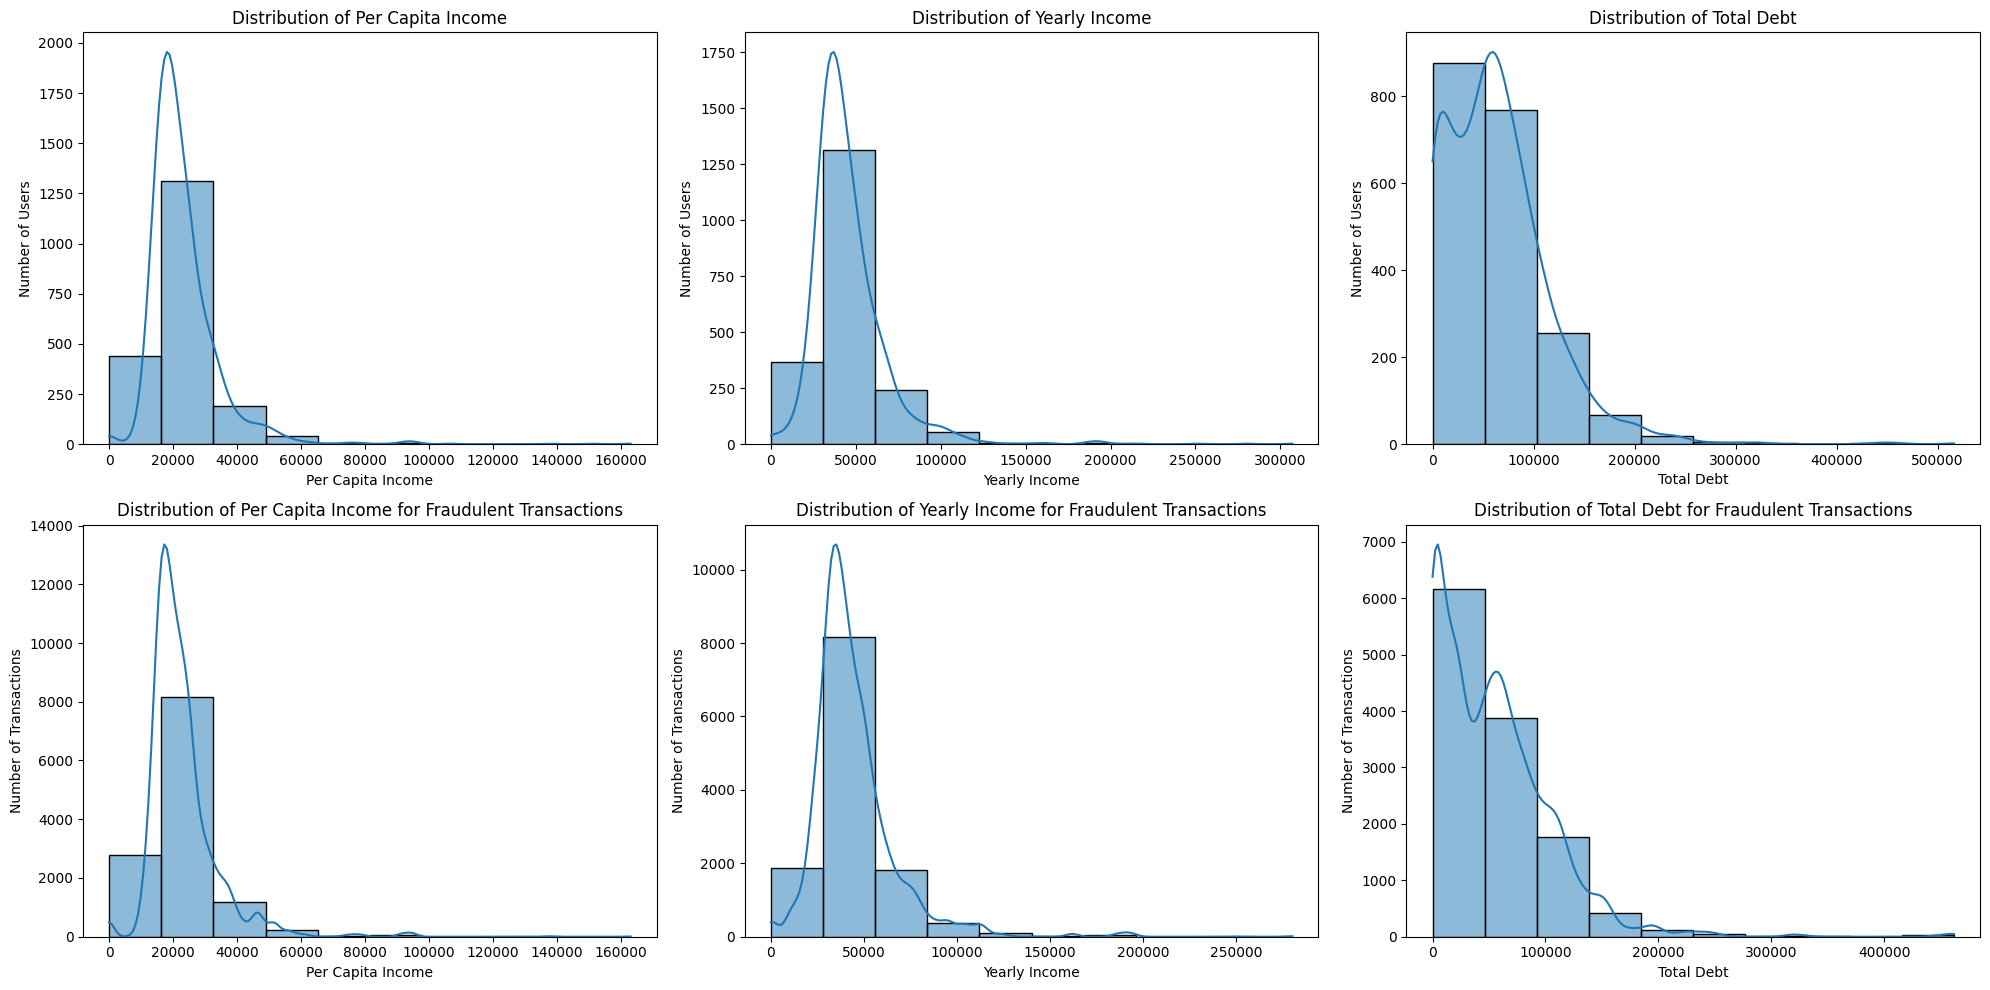

In [42]:
fig, ax = plt.subplots(2,3, figsize = (20,10))

sns.histplot(data=users_data, x='per_capita_income', bins=10, kde=True,ax=ax[0,0])
ax[0,0].set_title("Distribution of Per Capita Income")
ax[0,0].set_xlabel("Per Capita Income")
ax[0,0].set_ylabel("Number of Users")

sns.histplot(data=users_data, x='yearly_income', bins=10, kde=True,ax=ax[0,1])
ax[0,1].set_title("Distribution of Yearly Income")
ax[0,1].set_xlabel("Yearly Income")
ax[0,1].set_ylabel("Number of Users")

sns.histplot(data=users_data, x='total_debt', bins=10, kde=True,ax=ax[0,2])
ax[0,2].set_title("Distribution of Total Debt")
ax[0,2].set_xlabel("Total Debt")
ax[0,2].set_ylabel("Number of Users")

sns.histplot(data=transaction_fraud_yes, x='per_capita_income', bins=10, kde=True,ax=ax[1,0])
ax[1,0].set_title("Distribution of Per Capita Income for Fraudulent Transactions")
ax[1,0].set_xlabel("Per Capita Income")
ax[1,0].set_ylabel("Number of Transactions")

sns.histplot(data=transaction_fraud_yes, x='yearly_income', bins=10, kde=True,ax=ax[1,1])
ax[1,1].set_title("Distribution of Yearly Income for Fraudulent Transactions")
ax[1,1].set_xlabel("Yearly Income")
ax[1,1].set_ylabel("Number of Transactions")

sns.histplot(data=transaction_fraud_yes, x='total_debt', bins=10, kde=True,ax=ax[1,2])
ax[1,2].set_title("Distribution of Total Debt for Fraudulent Transactions")
ax[1,2].set_xlabel("Total Debt")
ax[1,2].set_ylabel("Number of Transactions")

plt.tight_layout()
plt.show()

Fraudulent transactions predominantly occur among users with low to mid-level income and debt, mirroring the overall user distribution, indicating that fraud risk aligns with population density rather than targeting specific financial profiles.

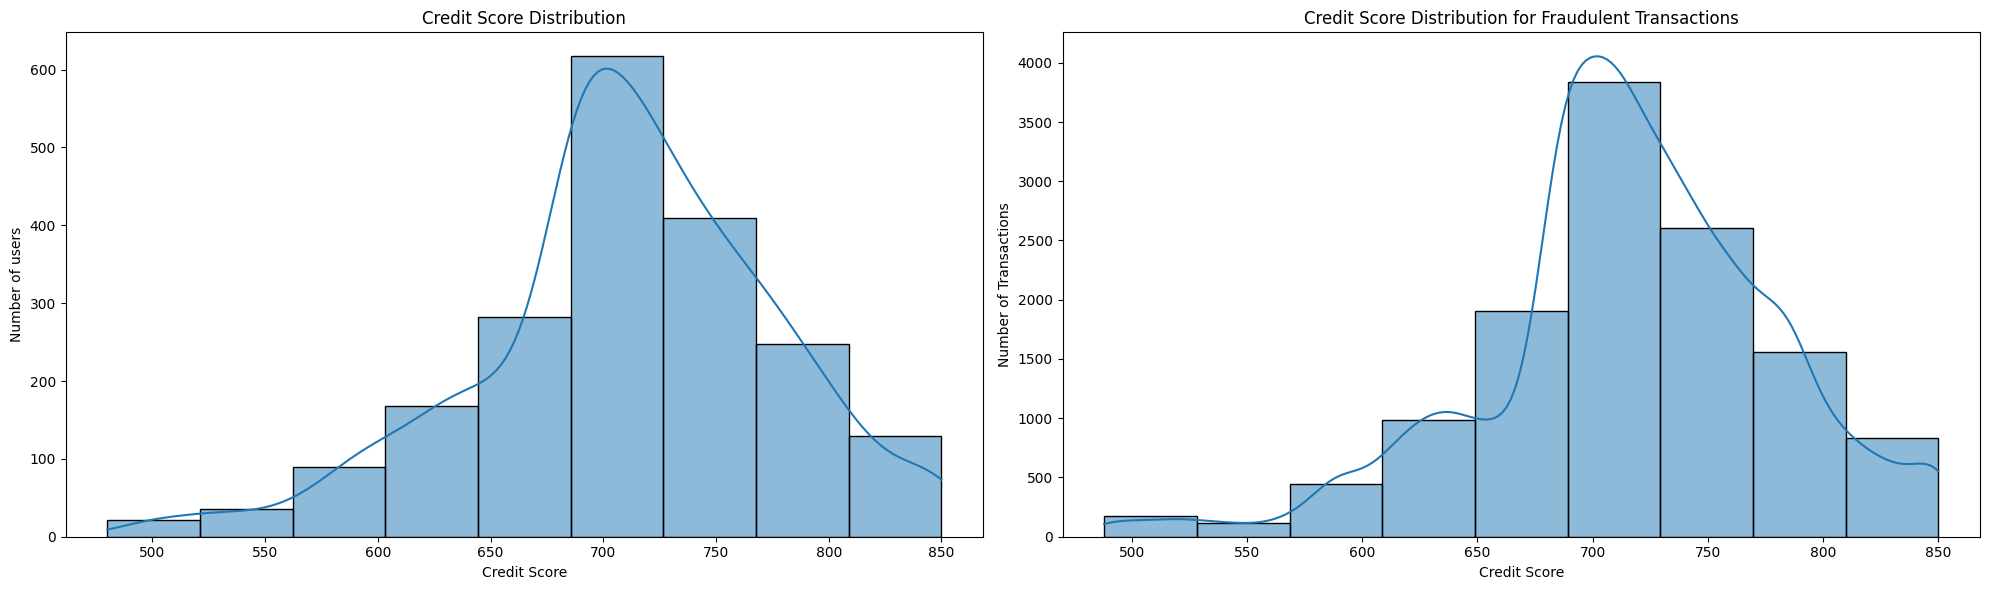

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.histplot(data=users_data, x='credit_score', bins=9, kde=True,ax=ax[0])
ax[0].set_title("Credit Score Distribution")
ax[0].set_xlabel("Credit Score")
ax[0].set_ylabel("Number of users")

sns.histplot(data=transaction_fraud_yes, x='credit_score', bins=9, kde=True,ax=ax[1])
ax[1].set_title("Credit Score Distribution for Fraudulent Transactions")
ax[1].set_xlabel("Credit Score")
ax[1].set_ylabel("Number of Transactions")

plt.tight_layout()
plt.show()

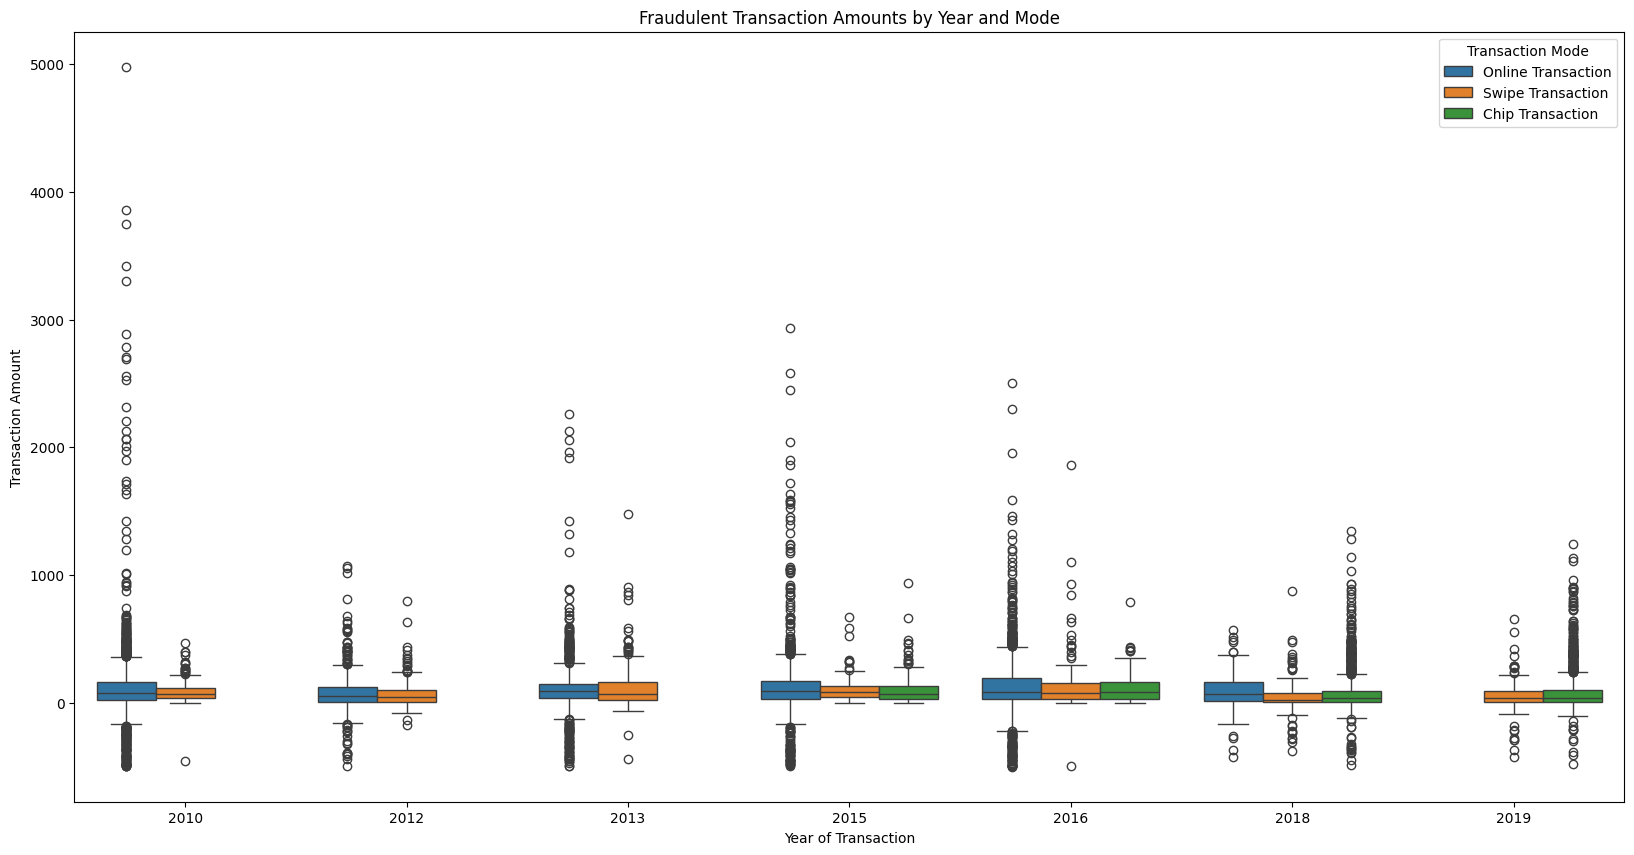

In [44]:
plt.figure(figsize=(20,10))
sns.boxplot(data=transaction_fraud_yes, x="year", y="amount", hue="transaction_mode")
plt.title("Fraudulent Transaction Amounts by Year and Mode")
plt.xlabel("Year of Transaction")
plt.ylabel("Transaction Amount")
plt.legend(title="Transaction Mode")
plt.show()

* Online transactions show the highest variability and most high-value fraudulent transactions. Swipe transactions declined in prominence and variability after 2014. Chip transactions emerged around 2015 with generally lower fraudulent amounts.
* 2010 – Highest fraud variability and extreme outliers, especially in online transactions. 2013, 2015, and 2016 also show high variability in online fraud, but less than 2010.
* 2015 – Chip-based fraud appears for the first time, marking a shift in transaction modes and fraud patterns
* While variability and outliers differ by mode and year, the overall average fraudulent amount stays relatively consistent throughout the dataset.

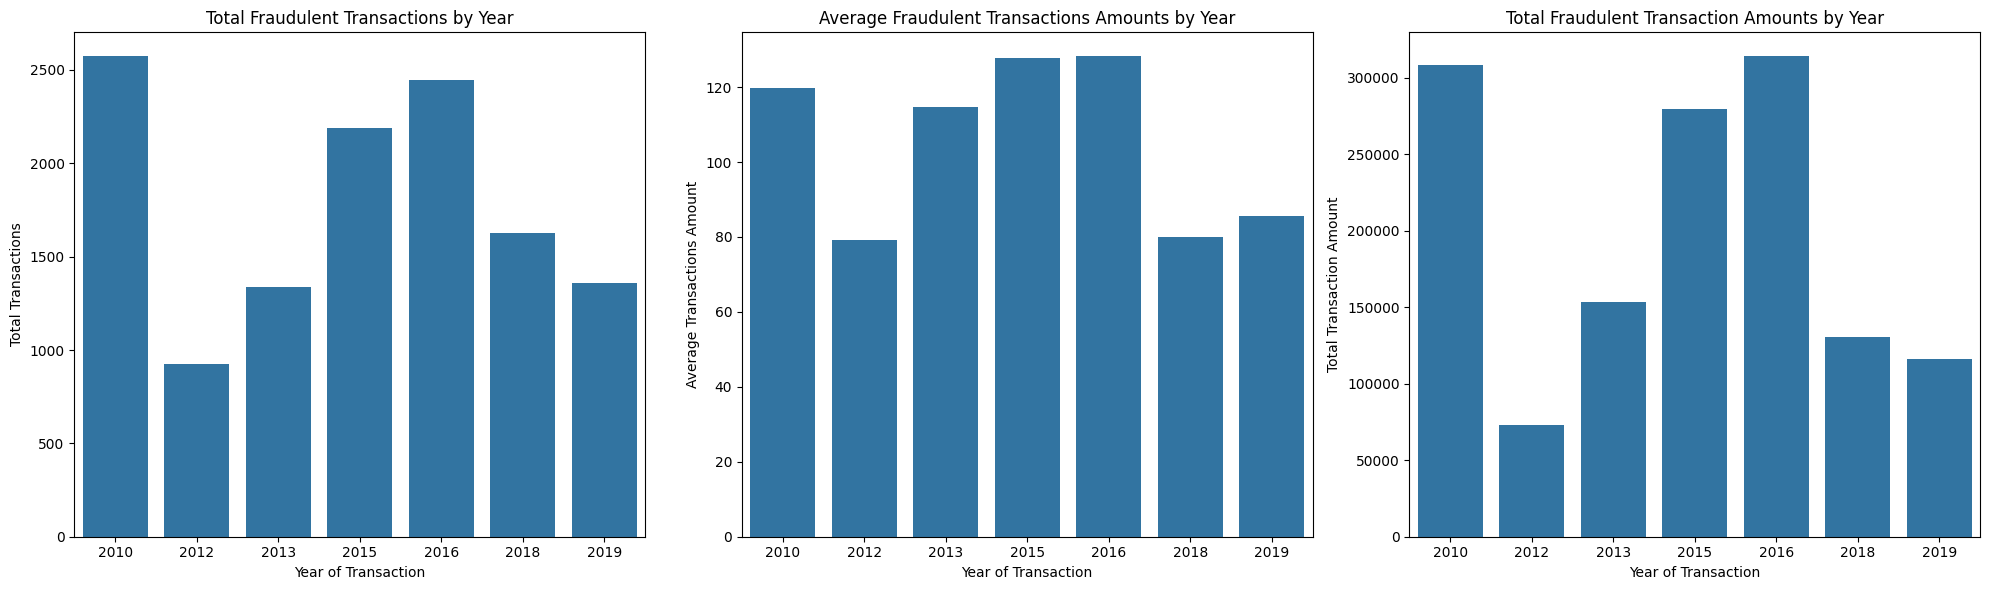

In [45]:
transaction_fraud_yes_grp_year= transaction_fraud_yes.groupby(['year'])['amount'].agg(
    mean_amount='mean',
    max_amount='max',
    min_amount='min',
    total_amount='sum',
    count = 'count')

fig, ax = plt.subplots(ncols=3, figsize=(20,6))

sns.barplot(x='year',y='count',data = transaction_fraud_yes_grp_year,ax=ax[0])
ax[0].set_title("Total Fraudulent Transactions by Year")
ax[0].set_xlabel("Year of Transaction")
ax[0].set_ylabel("Total Transactions")

sns.barplot(x='year',y='mean_amount',data = transaction_fraud_yes_grp_year,ax=ax[1])
ax[1].set_title("Average Fraudulent Transactions Amounts by Year")
ax[1].set_xlabel("Year of Transaction")
ax[1].set_ylabel("Average Transactions Amount")

sns.barplot(x='year',y='total_amount',data = transaction_fraud_yes_grp_year,ax=ax[2])
ax[2].set_title("Total Fraudulent Transaction Amounts by Year")
ax[2].set_xlabel("Year of Transaction")
ax[2].set_ylabel("Total Transaction Amount")

plt.tight_layout()
plt.show()

* 2010, 2015, and 2016 consistently show high transaction volume and total amounts.
* Transaction trends vary significantly year to year, suggesting external or internal factors influencing user activity.

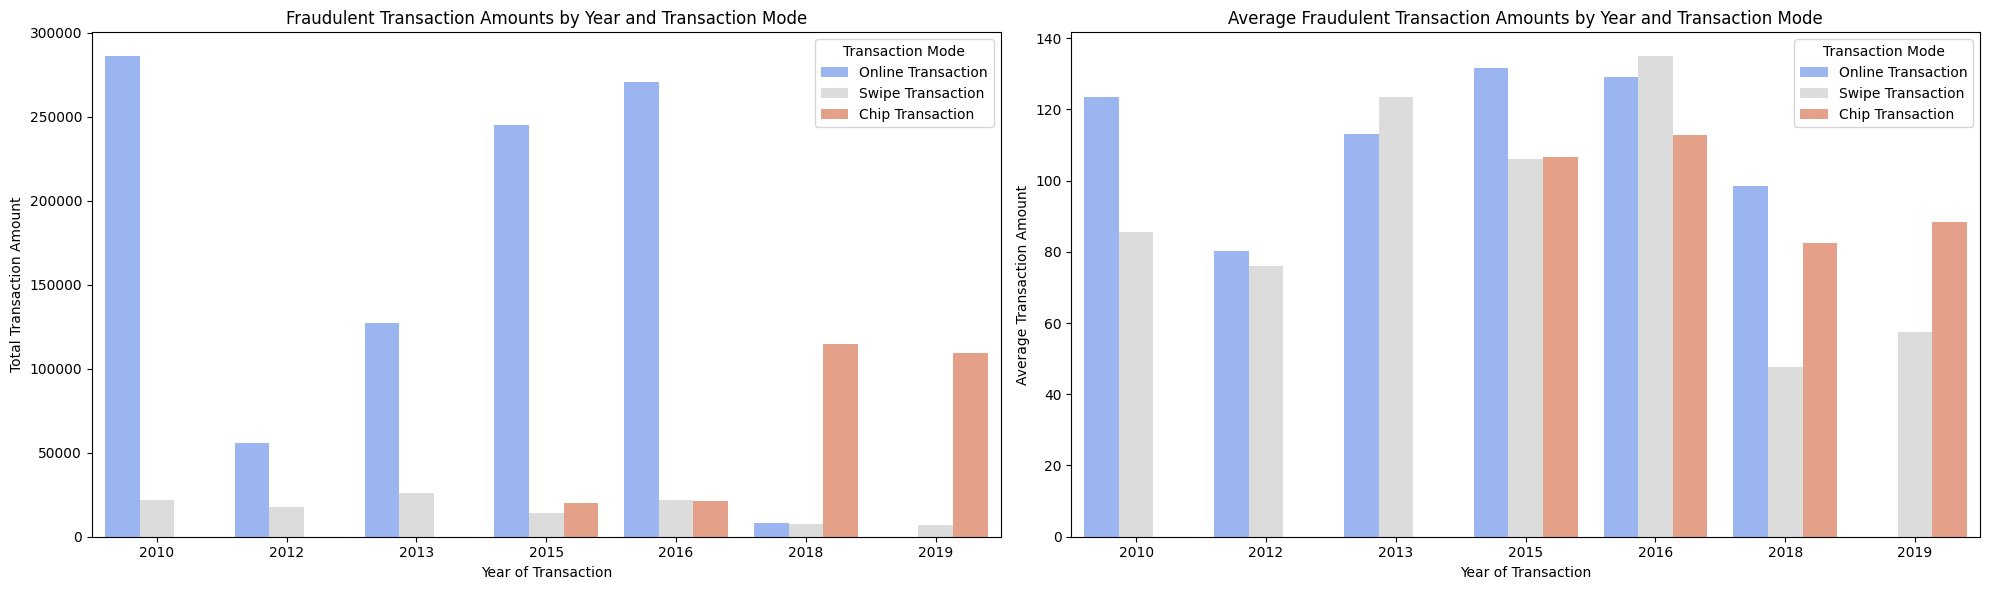

In [46]:
transaction_fraud_yes_grp_year_mode = transaction_fraud_yes.groupby(['transaction_mode','year'])['amount'].agg(
    mean_amount='mean',
    max_amount='max',
    min_amount='min',
    total_amount='sum',
    count = 'count'
)

transaction_fraud_yes_grp_year_mode = transaction_fraud_yes_grp_year_mode.reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(20,6))

sns.barplot(x="year", y="total_amount", palette="coolwarm", hue = 'transaction_mode', data =transaction_fraud_yes_grp_year_mode,ax=ax[0])
ax[0].set_title("Fraudulent Transaction Amounts by Year and Transaction Mode")
ax[0].set_xlabel("Year of Transaction")
ax[0].set_ylabel("Total Transaction Amount")
ax[0].legend(title="Transaction Mode")

sns.barplot(x="year", y="mean_amount", palette="coolwarm", hue = 'transaction_mode', data =transaction_fraud_yes_grp_year_mode,ax=ax[1])
ax[1].set_title("Average Fraudulent Transaction Amounts by Year and Transaction Mode")
ax[1].set_xlabel("Year of Transaction")
ax[1].set_ylabel("Average Transaction Amount")
ax[1].legend(title="Transaction Mode")

plt.tight_layout()
plt.show()

* Online mode leads in both mean and total transaction values, especially between 2010–2016. Chip transactions rose steadily after 2015, with increased usage but lower per-transaction value.
* Swipe transactions show decline post-2015 and have inconsistent usage and values, suggesting they are being phased out or used for non-standard cases.


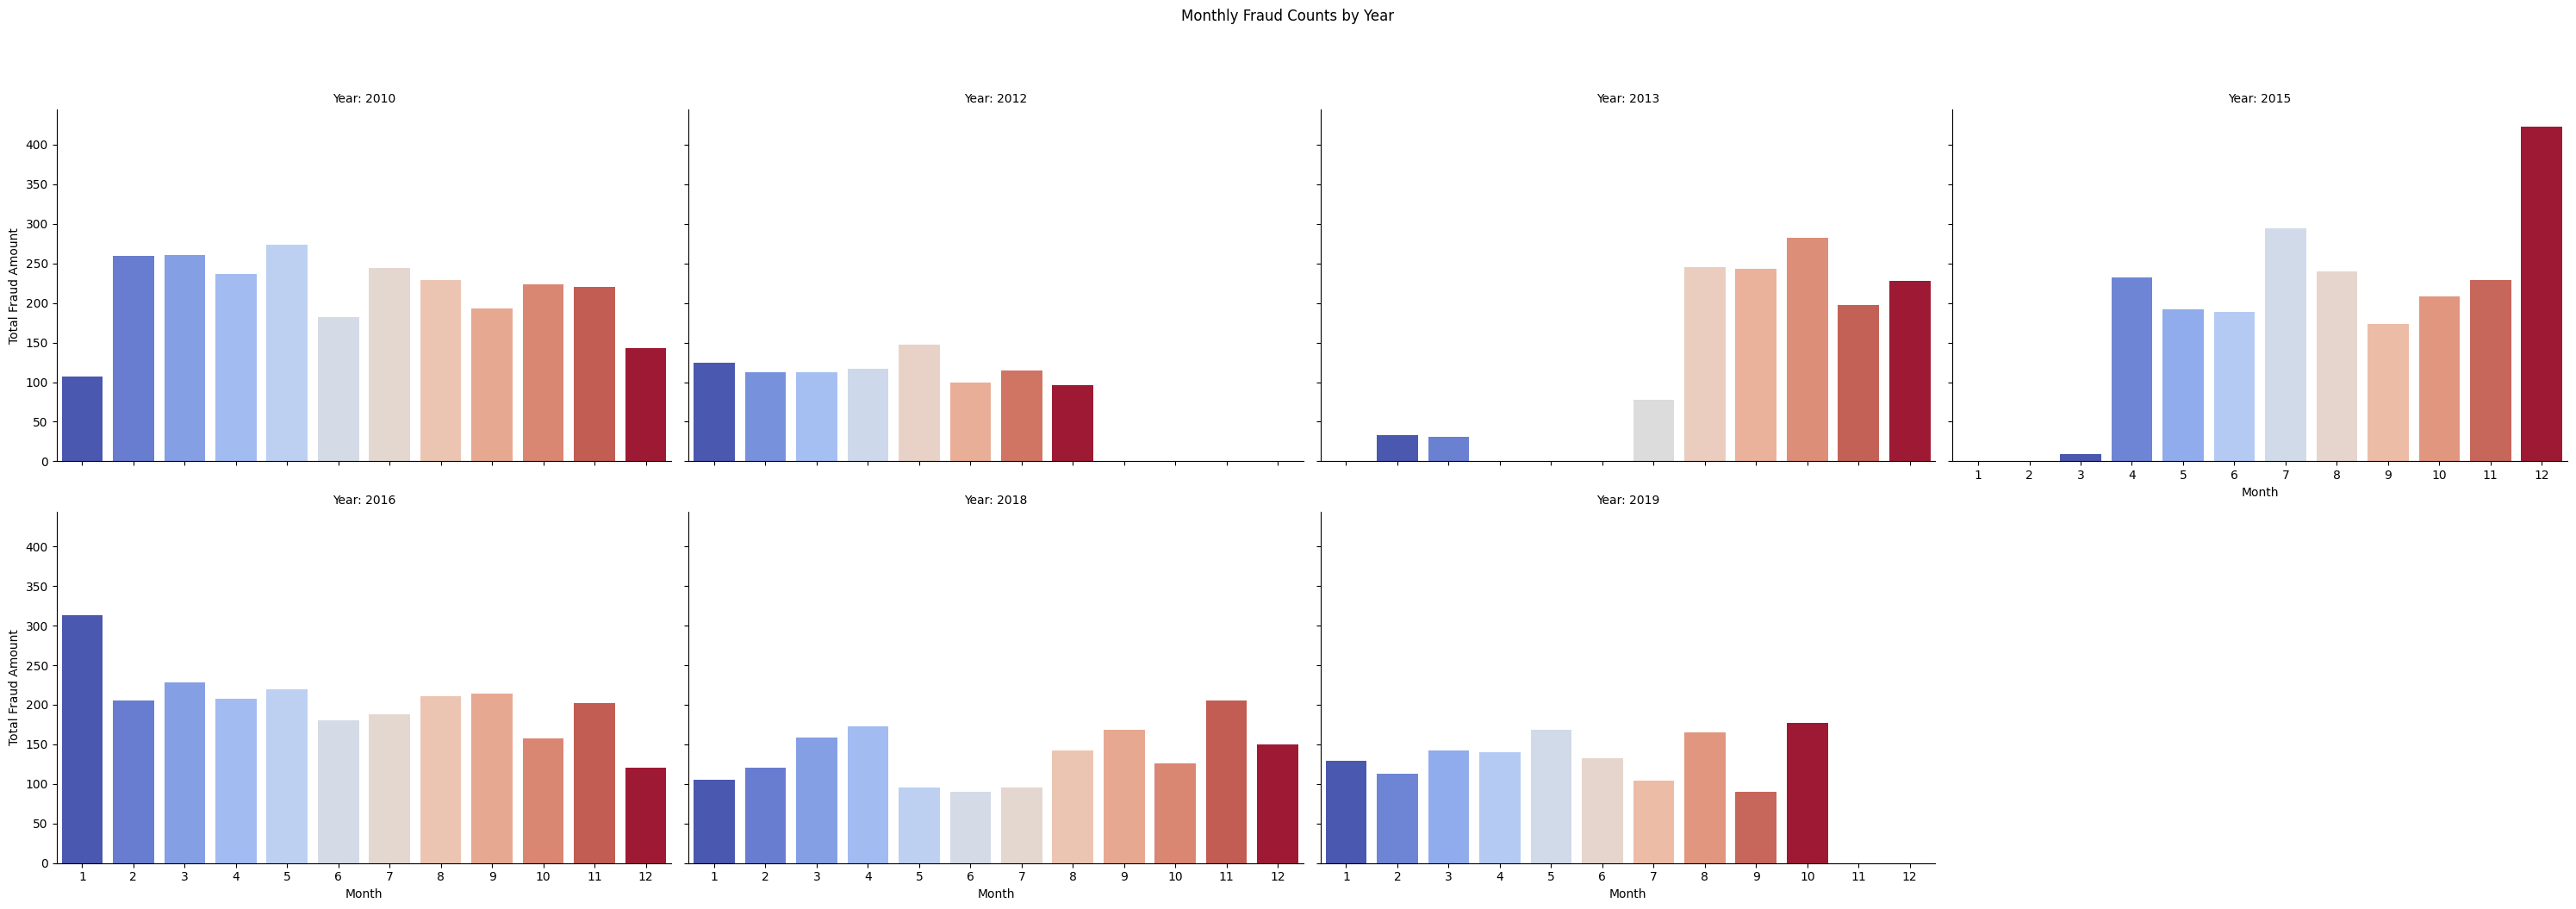

In [47]:
transaction_fraud_yes_grp_year_month = transaction_fraud_yes.groupby(['month','year'])['amount'].agg(
    mean_amount='mean',
    max_amount='max',
    min_amount='min',
    total_amount='sum',
    count = 'count'
)

transaction_fraud_yes_grp_year_month = transaction_fraud_yes_grp_year_month.reset_index()

g = sns.FacetGrid(transaction_fraud_yes_grp_year_month, col="year", col_wrap=4, height=5, aspect=1.5)
g.map_dataframe(sns.barplot, x="month", y="count", palette="coolwarm", hue = 'month')
g.set_titles("Year: {col_name}")
g.set_axis_labels("Month", "Total Fraud Amount")
g.fig.suptitle("Monthly Fraud Counts by Year", y=1.05)
plt.tight_layout()
plt.show()

* Fraud activity peaks during key seasonal periods, with notable spikes in December and early in the year, indicating elevated risk around the holiday season and at the start of the year.
* Seasonality is evident, with fraud patterns peaking primarily in the end-of-year months across multiple years.

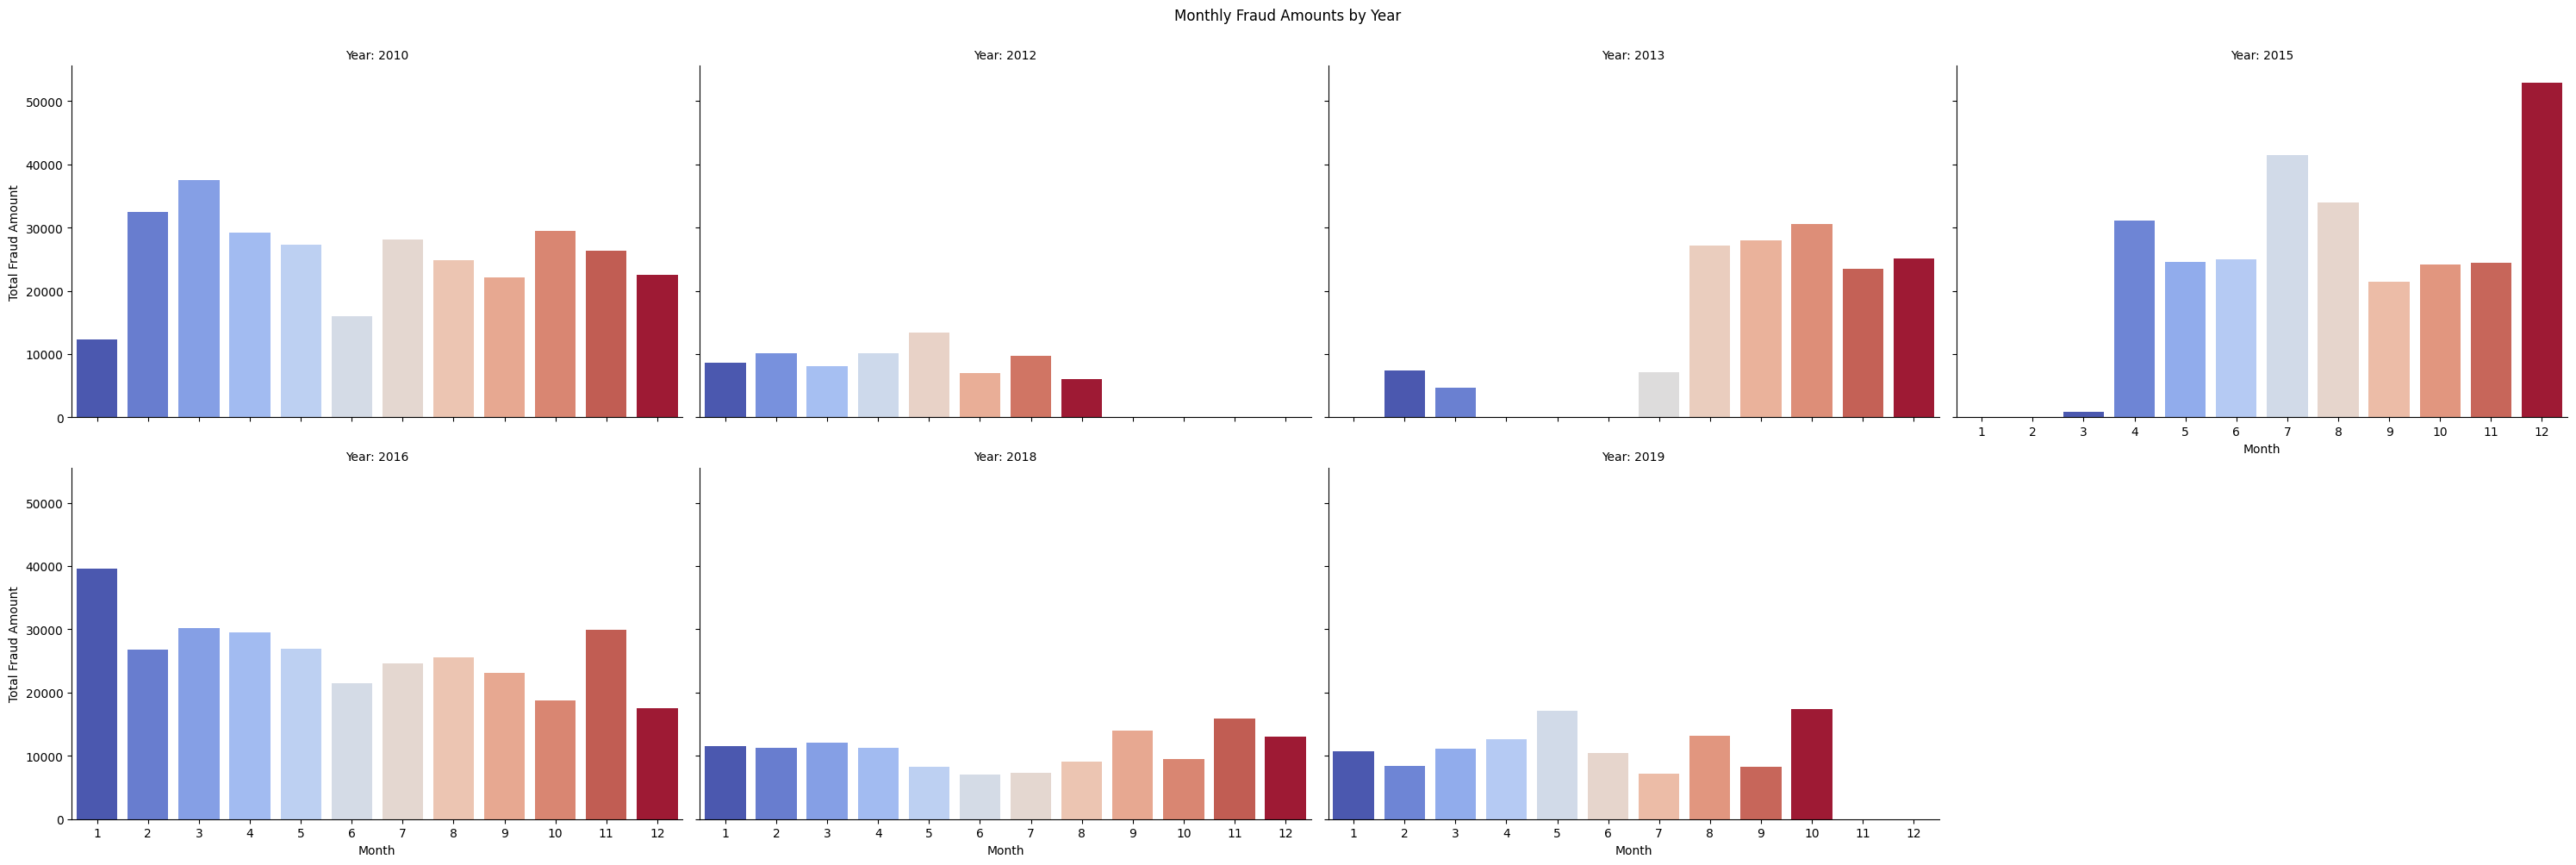

In [48]:
g = sns.FacetGrid(transaction_fraud_yes_grp_year_month, col="year", col_wrap=4, height=5, aspect=1.5)
g.map_dataframe(sns.barplot, x="month", y="total_amount", palette="coolwarm", hue = 'month')
g.set_titles("Year: {col_name}")
g.set_axis_labels("Month", "Total Fraud Amount")
g.fig.suptitle("Monthly Fraud Amounts by Year", y=1)
plt.tight_layout()
plt.show()

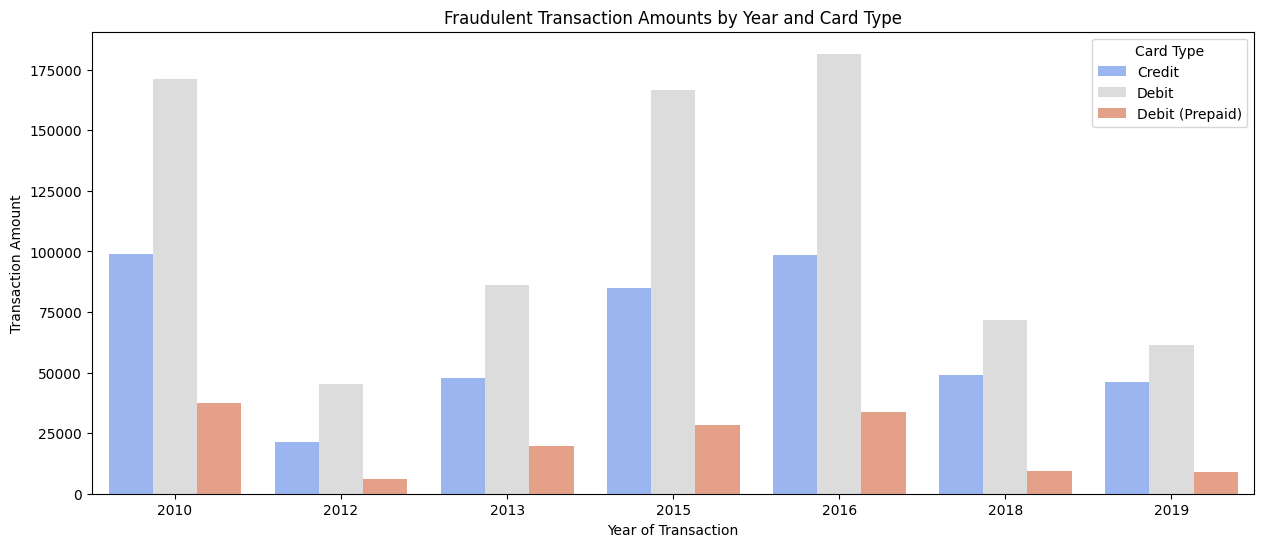

In [49]:
transaction_fraud_yes_grp_year_type = transaction_fraud_yes.groupby(['card_type','year'])['amount'].agg(
    mean_amount='mean',
    total_amount='sum',
    count = 'count'
)

transaction_fraud_yes_grp_year_mode = transaction_fraud_yes_grp_year_mode.reset_index()

plt.subplots( figsize = (15,6))
sns.barplot(x="year", y="total_amount", palette="coolwarm", hue = 'card_type', data =transaction_fraud_yes_grp_year_type)
plt.title("Fraudulent Transaction Amounts by Year and Card Type")
plt.xlabel("Year of Transaction")
plt.ylabel("Transaction Amount")
plt.legend(title="Card Type")
plt.show()

* Debit cards dominate in transaction volume and consistency, making them a central focus for trends and fraud analysis. Credit cards saw peak usage early (2010) and mid-decade (2016), but declined significantly after. Prepaid debit cards are niche, with occasional spikes in mean amount but low usage overall.



In [50]:
get_data_card(final_df)

Shape of given data is (6199178, 34)

Count of duplicate values is 0

Null Values ===> 

date                           0
client_id                      0
card_id                        0
amount                         0
transaction_mode               0
merchant_id                    0
merchant_city                  0
merchant_state            732357
zip                       773946
mcc                            0
error                    6100637
transaction_id                 0
fraud                          0
card_brand                     0
card_type                      0
expires                        0
has_chip                       0
num_cards_issued               0
credit_limit                   0
acct_open_date                 0
year_pin_last_changed          0
current_age                    0
retirement_age                 0
birth_year                     0
birth_month                    0
gender                         0
per_capita_income              0
yearly_income       

##### Date related analysis

In [51]:
date_fraud_df = transaction_fraud_yes[['client_id','date','month','year','current_age','has_chip','transaction_mode','card_brand','gender','fraud','amount']].copy()
date_fraud_df['day'] = date_fraud_df['date'].dt.day
date_fraud_df['day_name'] = date_fraud_df['date'].dt.day_name()
date_fraud_df['is_weekend'] = date_fraud_df['date'].dt.weekday >= 5
date_fraud_df['day_type'] = date_fraud_df['is_weekend'].map({True: 'Weekend', False: 'Weekday'})
date_fraud_df['hour'] = date_fraud_df['date'].dt.hour
date_fraud_df['hour_minute'] = date_fraud_df['date'].dt.strftime('%H:%M')
date_fraud_df.head()

,client_id,date,month,year,current_age,has_chip,transaction_mode,card_brand,gender,fraud,amount,day,day_name,is_weekend,day_type,hour,hour_minute
3459,126,2010-01-01 23:56:00,1,2010,63,YES,Online Transaction,Mastercard,Male,Yes,0.19,1,Friday,False,Weekday,23,23:56
9526,126,2010-01-03 20:58:00,1,2010,63,YES,Online Transaction,Mastercard,Male,Yes,339.00,3,Sunday,True,Weekend,20,20:58
12989,720,2010-01-04 23:30:00,1,2010,36,YES,Online Transaction,Mastercard,Female,Yes,4.45,4,Monday,False,Weekday,23,23:30
13000,720,2010-01-04 23:48:00,1,2010,36,YES,Online Transaction,Mastercard,Female,Yes,7.19,4,Monday,False,Weekday,23,23:48
13081,1644,2010-01-05 02:34:00,1,2010,83,YES,Online Transaction,Visa,Male,Yes,8.76,5,Tuesday,False,Weekday,2,02:34


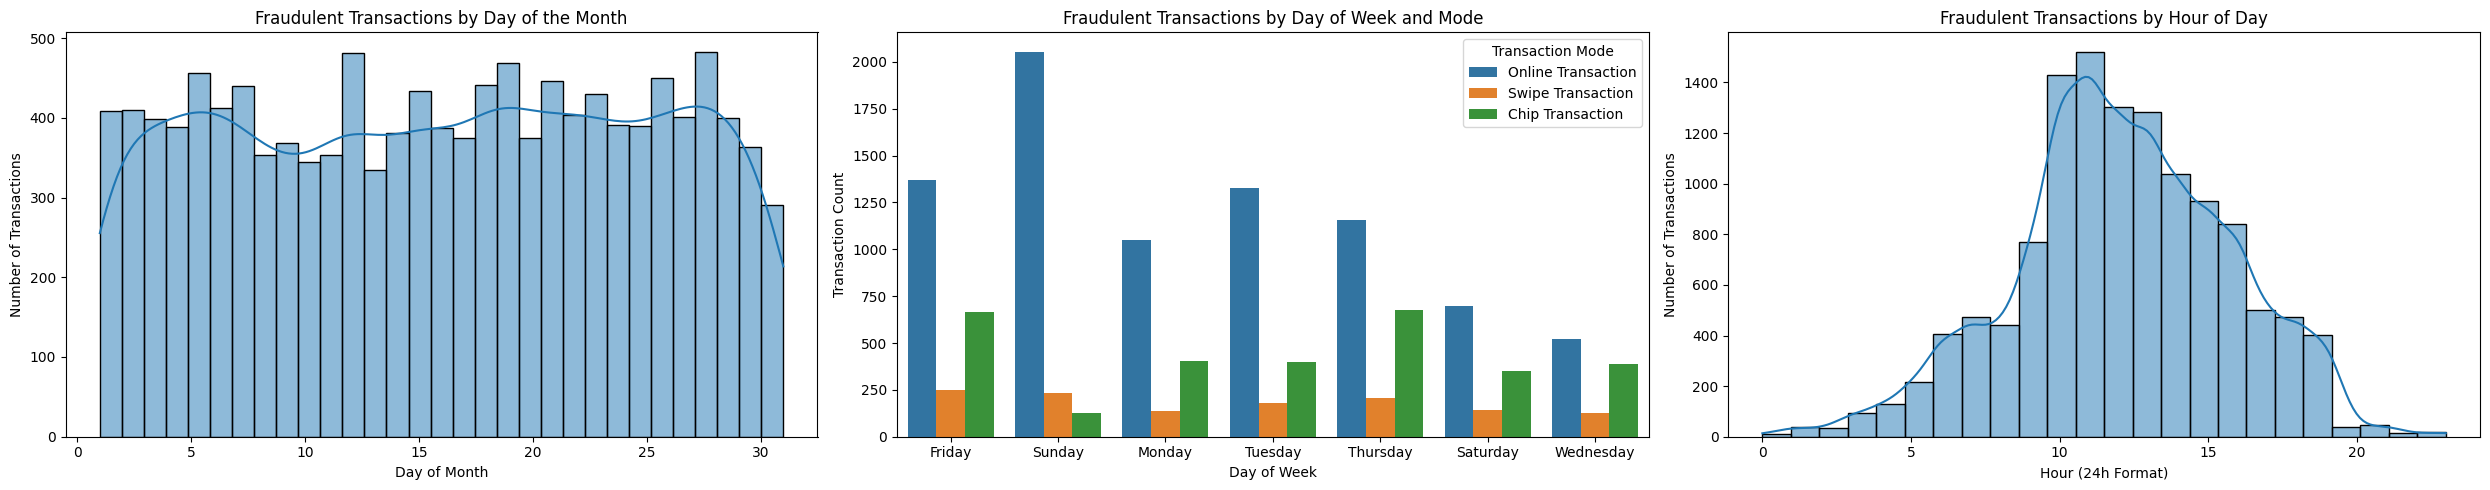

In [52]:
fig, ax = plt.subplots(1,3, figsize = (25,5))

sns.histplot(data=date_fraud_df, x='day', bins=31, kde=True,ax=ax[0])
ax[0].set_title("Fraudulent Transactions by Day of the Month")
ax[0].set_xlabel("Day of Month")
ax[0].set_ylabel("Number of Transactions")

sns.countplot(data=date_fraud_df, x='day_name', hue='transaction_mode',ax=ax[1])
ax[1].set_title("Fraudulent Transactions by Day of Week and Mode")
ax[1].set_xlabel("Day of Week")
ax[1].set_ylabel("Transaction Count")
ax[1].legend(title="Transaction Mode")

sns.histplot(data=date_fraud_df, x='hour', bins=24, kde=True,ax=ax[2])
ax[2].set_title("Fraudulent Transactions by Hour of Day")
ax[2].set_xlabel("Hour (24h Format)")
ax[2].set_ylabel("Number of Transactions")


plt.tight_layout()
plt.show()

* Fraudulent transactions are consistently distributed across the days of the month, showing no significant daily anomalies.
* Transaction spikes are observed on Sundays, Fridays, and Tuesdays, with Sunday standing out, it is the only day where swipe fraud exceeds chip-based fraud. Online transactions consistently lead in fraud volume across all days, indicating they remain the primary channel for fraudulent activity.

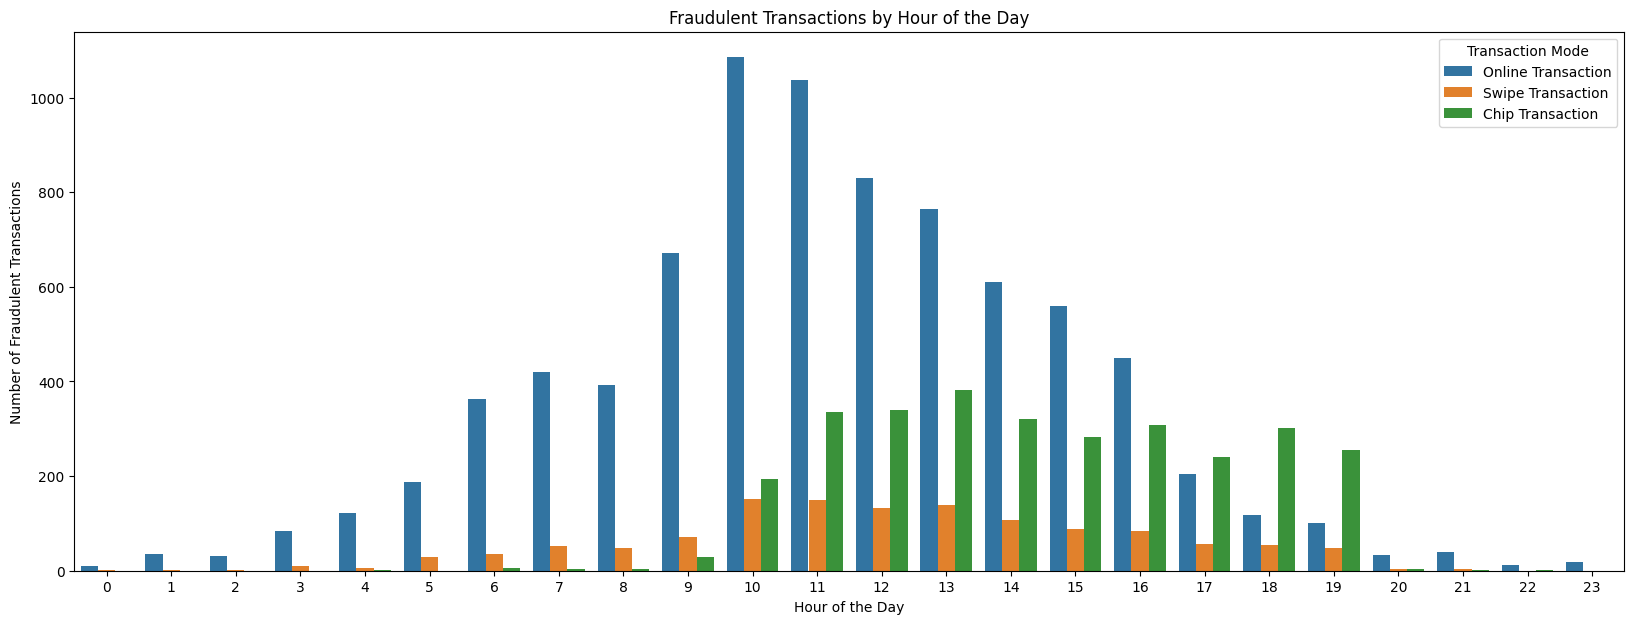

In [53]:
fig, ax = plt.subplots(figsize = (20,7))
sns.countplot(data=date_fraud_df, x='hour',hue='transaction_mode')
plt.title("Fraudulent Transactions by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Fraudulent Transactions")
plt.legend(title="Transaction Mode")
plt.show()

* Most fraudulent transactions occur between 10:00 AM and 12:00 PM, with online transactions dominating during this peak window.

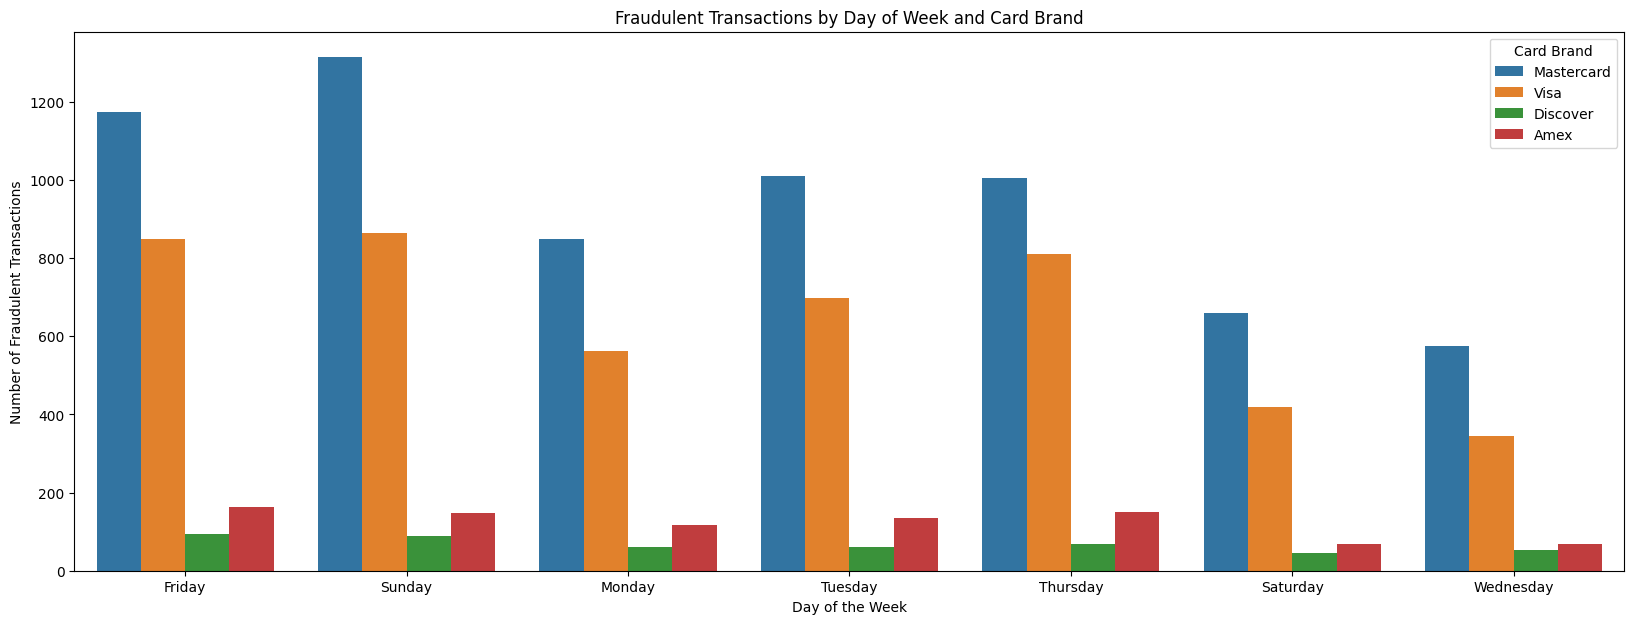

In [54]:
fig, ax = plt.subplots(figsize = (20,7))
sns.countplot(data=date_fraud_df, x='day_name',hue='card_brand')
plt.title("Fraudulent Transactions by Day of Week and Card Brand")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Fraudulent Transactions")
plt.legend(title="Card Brand")
plt.show()

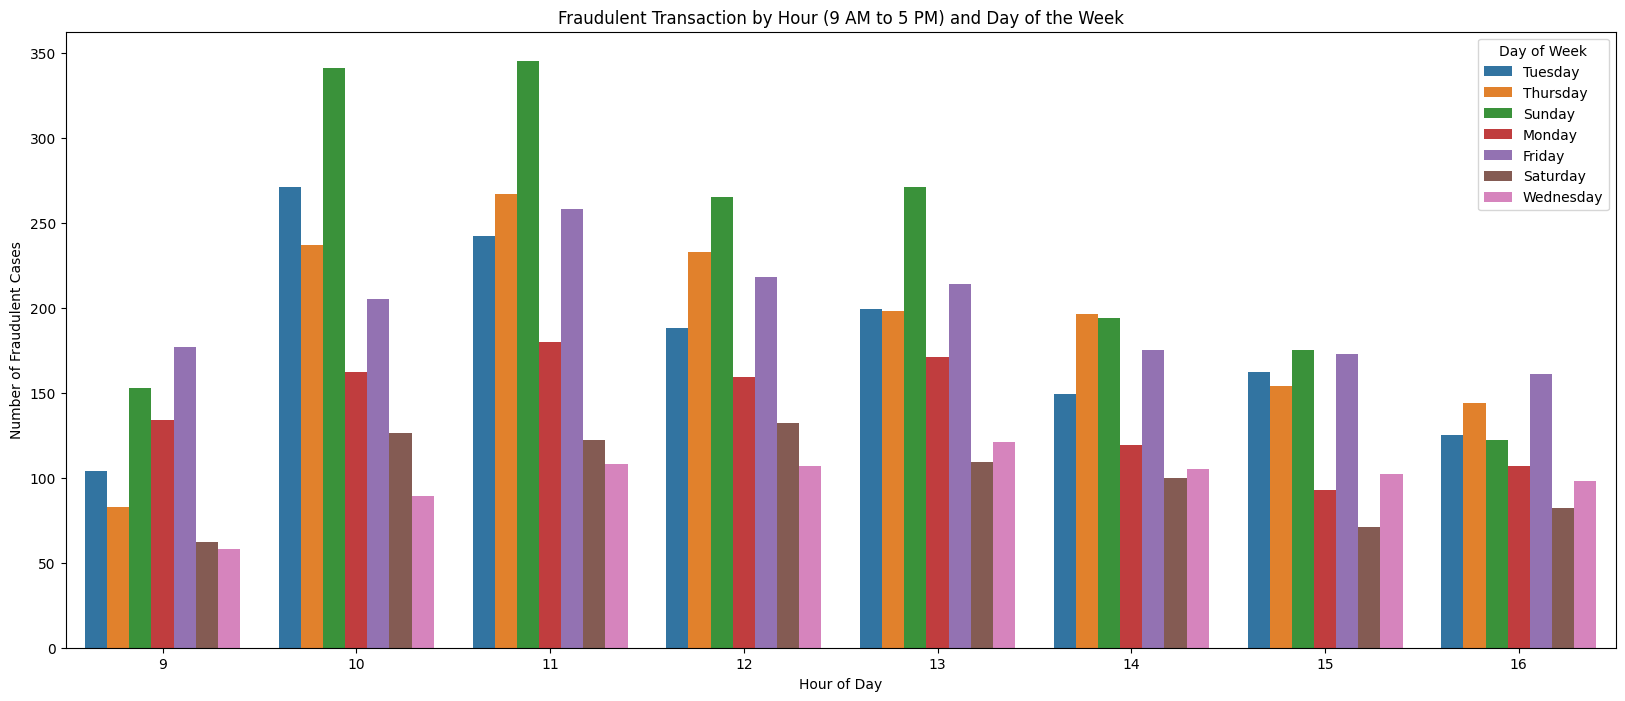

In [55]:
fig, ax = plt.subplots(figsize = (20,8))
sns.countplot(data=date_fraud_df[(date_fraud_df.hour>=9) & (date_fraud_df.hour<17)], x='hour',hue='day_name')
plt.title("Fraudulent Transaction by Hour (9 AM to 5 PM) and Day of the Week")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Fraudulent Cases")
plt.legend(title="Day of Week")
plt.show()

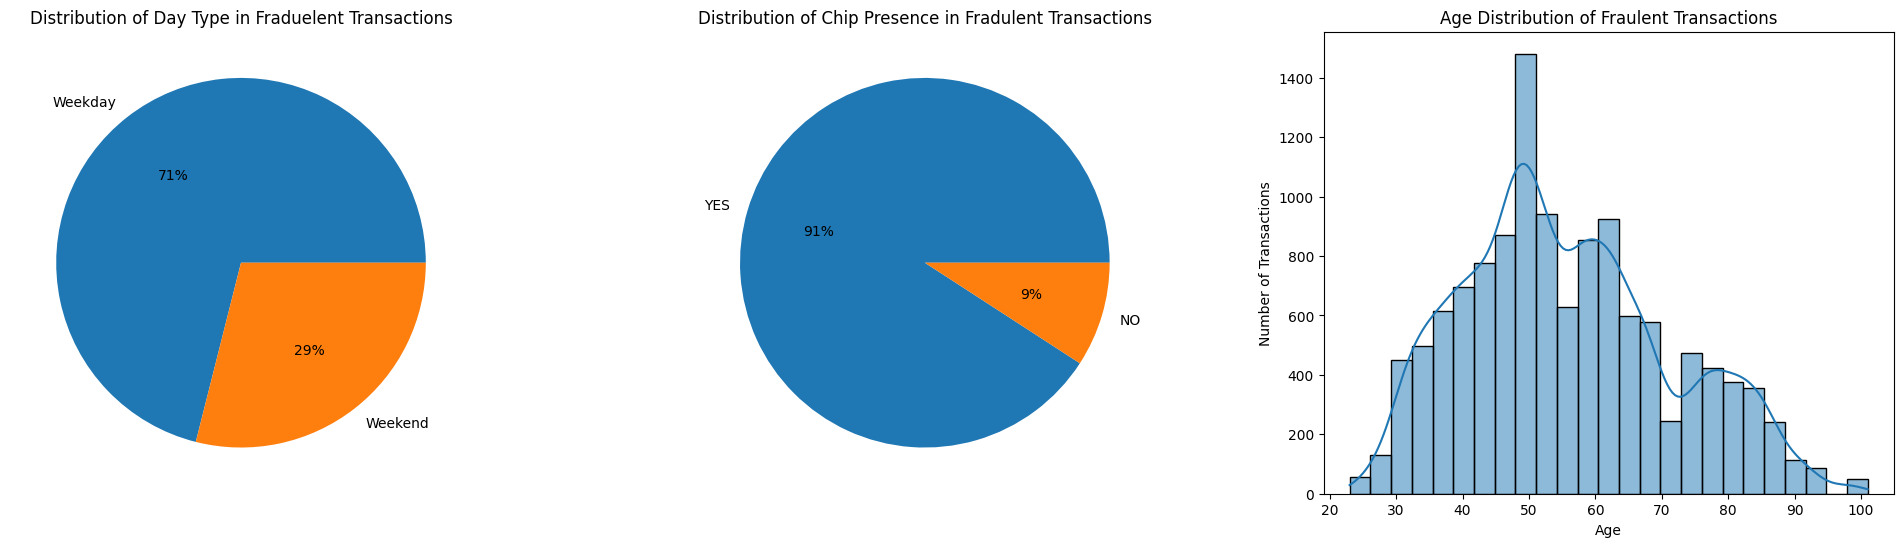

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(25, 6))

labels = date_fraud_df.day_type.value_counts().index.tolist()
data = date_fraud_df.day_type.value_counts().values
palette_color = sns.color_palette('tab10')
ax[0].pie(data, labels=labels, colors=palette_color, autopct='%.0f%%')
ax[0].set_title("Distribution of Day Type in Fraduelent Transactions")

labels = date_fraud_df.has_chip.value_counts().index.tolist()
data = date_fraud_df.has_chip.value_counts().values
ax[1].pie(data, labels=labels, colors=palette_color, autopct='%.0f%%')
ax[1].set_title("Distribution of Chip Presence in Fradulent Transactions")

sns.histplot(data=date_fraud_df, x='current_age', bins=25, kde=True)
ax[2].set_title("Age Distribution of Fraulent Transactions")
ax[2].set_xlabel("Age")
ax[2].set_ylabel("Number of Transactions")
plt.show()

plt.show()


Fraudulent transactions span all age groups, but are most concentrated among individuals aged 50, with secondary peaks in the 60-63 range, while very young and elderly individuals show lower involvement

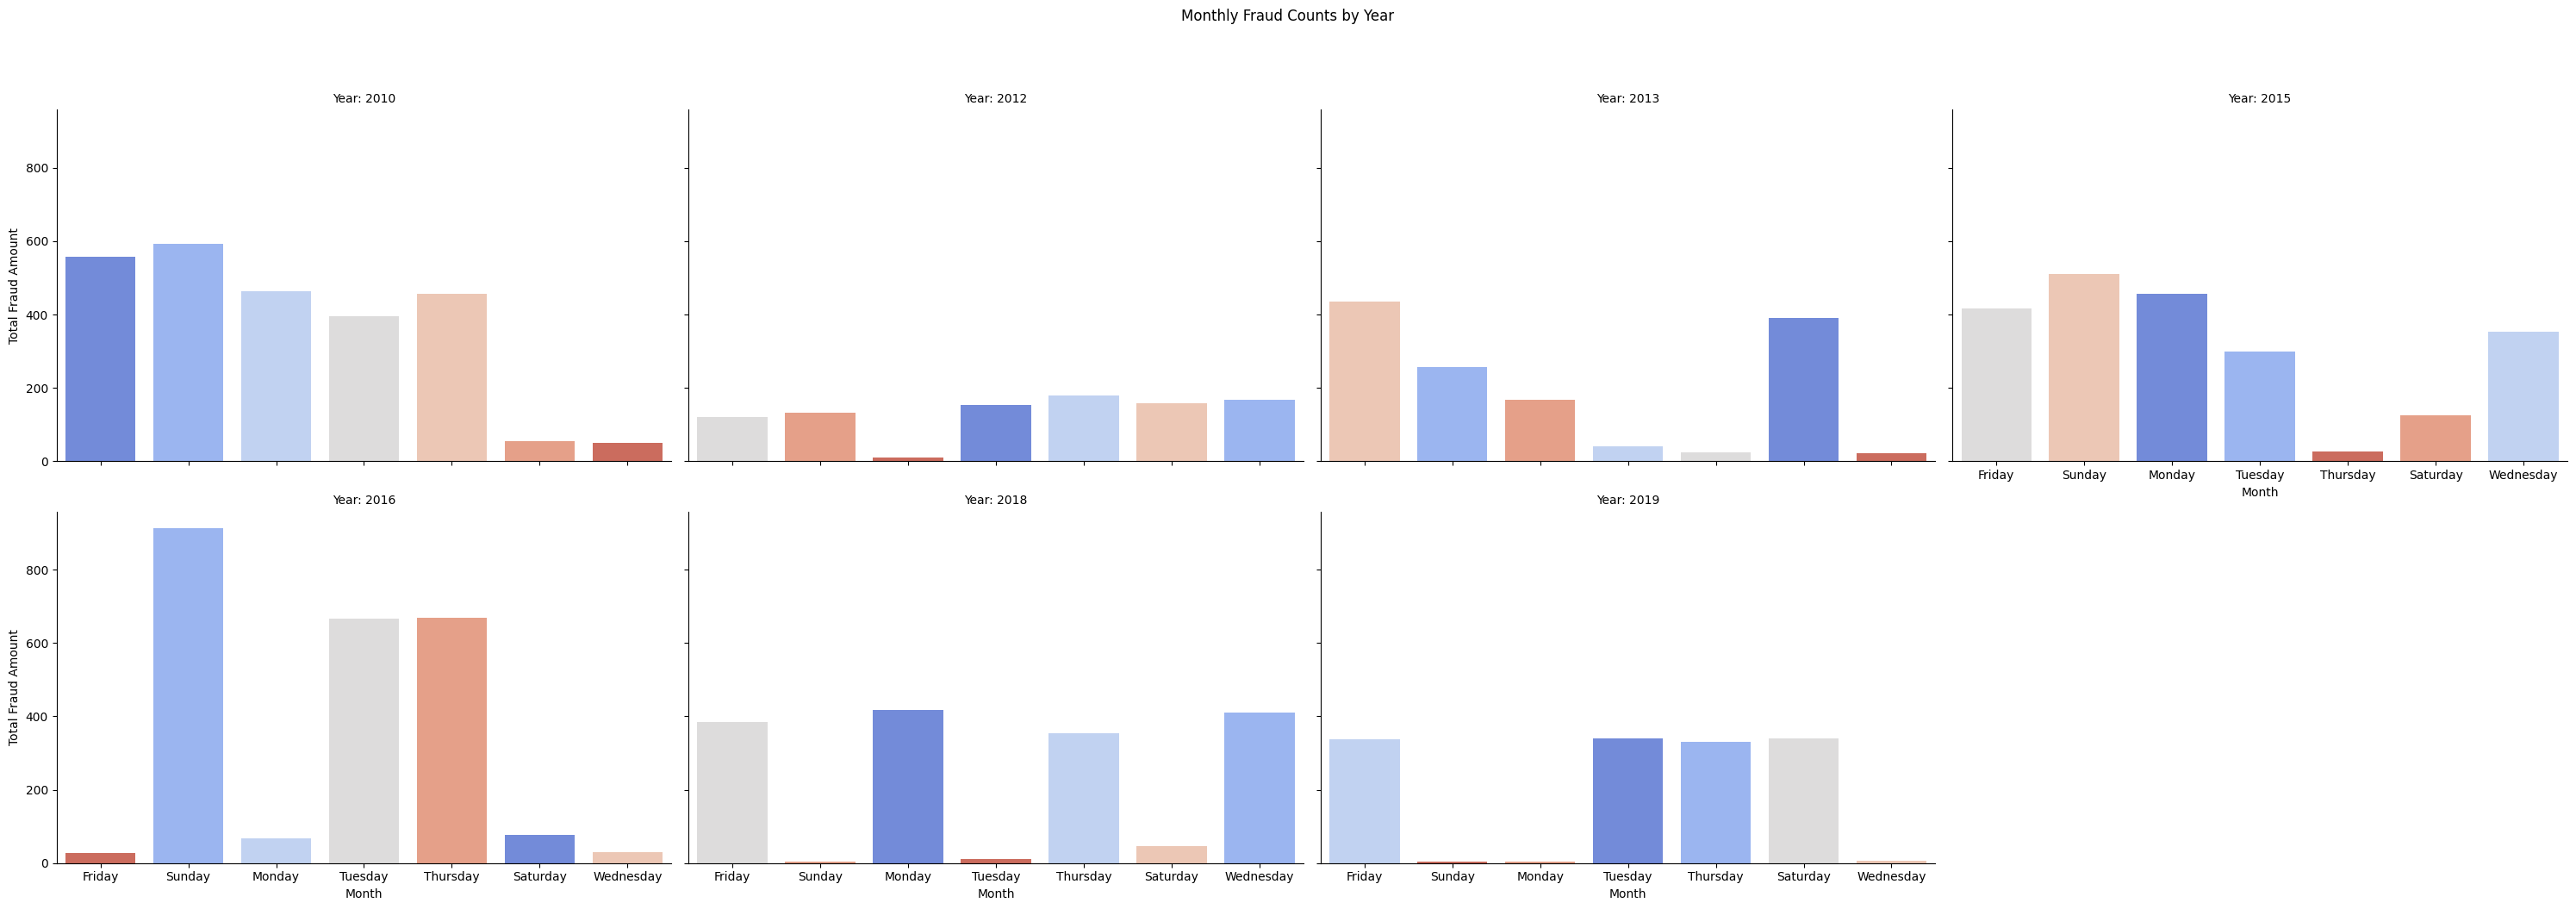

In [57]:
g = sns.FacetGrid(date_fraud_df, col="year", col_wrap=4, height=5, aspect=1.5)
g.map_dataframe(sns.countplot, x="day_name", palette="coolwarm", hue = 'day_name')
g.set_titles("Year: {col_name}")
g.set_axis_labels("Month", "Total Fraud Amount")
g.fig.suptitle("Monthly Fraud Counts by Year", y=1.05)
plt.tight_layout()
plt.show()

Fraudulent activity tends to peak on Sundays, Mondays, and Tuesdays, with Sunday standing out as a high risk day across several years. While weekdays see consistent fraud, weekend fraud particularly on Sundays demands closer attention, especially in high-activity years like 2015–2016.

In [58]:
date_fraud_df.head()

,client_id,date,month,year,current_age,has_chip,transaction_mode,card_brand,gender,fraud,amount,day,day_name,is_weekend,day_type,hour,hour_minute
3459,126,2010-01-01 23:56:00,1,2010,63,YES,Online Transaction,Mastercard,Male,Yes,0.19,1,Friday,False,Weekday,23,23:56
9526,126,2010-01-03 20:58:00,1,2010,63,YES,Online Transaction,Mastercard,Male,Yes,339.00,3,Sunday,True,Weekend,20,20:58
12989,720,2010-01-04 23:30:00,1,2010,36,YES,Online Transaction,Mastercard,Female,Yes,4.45,4,Monday,False,Weekday,23,23:30
13000,720,2010-01-04 23:48:00,1,2010,36,YES,Online Transaction,Mastercard,Female,Yes,7.19,4,Monday,False,Weekday,23,23:48
13081,1644,2010-01-05 02:34:00,1,2010,83,YES,Online Transaction,Visa,Male,Yes,8.76,5,Tuesday,False,Weekday,2,02:34


### EDA

In [59]:
final_df

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,transaction_id,fraud,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_year,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,Description,year,month
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,7475327.0,No,Mastercard,Debit (Prepaid),07/2022,YES,2,55.0,05/2008,2008,30,67,1989,7,Female,23679.0,48277.0,110153.0,740,4,Miscellaneous Food Stores,2010,1
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,7475328.0,No,Mastercard,Credit,12/2024,YES,1,9100.0,09/2005,2015,48,67,1971,6,Male,18076.0,36853.0,112139.0,834,5,Department Stores,2010,1
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,7475329.0,No,Mastercard,Debit,05/2020,YES,1,14802.0,01/2006,2008,49,65,1970,4,Male,16894.0,34449.0,36540.0,686,3,Money Transfer,2010,1
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,7475332.0,No,Visa,Debit,01/2020,YES,1,19113.0,07/2009,2014,51,69,1968,5,Male,33529.0,68362.0,96182.0,711,2,Drinking Places (Alcoholic Beverages),2010,1
5,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464,5942,None,7475333.0,No,Mastercard,Debit (Prepaid),03/2014,YES,1,89.0,01/2008,2015,47,65,1972,12,Female,25537.0,52065.0,98613.0,828,5,Book Stores,2010,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13305905,2019-10-31 23:54:00,672,5001,12.93,Chip Transaction,47508,Cosby,TN,37722,7230,None,23761862.0,No,Visa,Debit,01/2020,YES,1,8333.0,10/2003,2007,37,68,1983,2,Male,11755.0,23967.0,3880.0,722,4,Beauty and Barber Shops,2019,10
13305906,2019-10-31 23:54:00,1384,3723,67.01,Chip Transaction,58136,Williamson,GA,30292,5812,None,23761863.0,No,Visa,Debit,02/2020,YES,2,24617.0,07/2004,2006,74,67,1946,1,Female,22545.0,23011.0,30510.0,721,3,Eating Places and Restaurants,2019,10
13305910,2019-10-31 23:56:00,1718,2379,1.11,Chip Transaction,86438,West Covina,CA,91792,5499,None,23761868.0,No,Mastercard,Debit,02/2020,YES,1,26743.0,03/2019,2019,81,67,1938,11,Female,22681.0,33483.0,196.0,698,5,Miscellaneous Food Stores,2019,10
13305911,2019-10-31 23:56:00,1766,2066,12.80,Online Transaction,39261,ONLINE,None,None,5815,None,23761869.0,No,Mastercard,Debit,06/2024,YES,1,5141.0,03/2004,2012,62,66,1957,9,Male,9995.0,20377.0,12092.0,789,4,"Digital Goods - Media, Books, Apps",2019,10


In [60]:
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
final_df['neg_amount'] = np.where(final_df['amount']<0,'Yes','No')
final_df['transaction_id'] = final_df['transaction_id'].astype('int')
final_df['fraud'] = final_df['fraud'].map({'Yes': 1, 'No': 0})
final_df['fraud'] = final_df['fraud'].astype('int')
final_df['log_amount'] = np.log1p(final_df.amount)
final_df['day'] = final_df['date'].dt.day
final_df['day_name'] = final_df['date'].dt.day_name()
final_df['is_weekend'] = final_df['date'].dt.weekday >= 5
final_df['day_type'] = final_df['is_weekend'].map({True: 'Weekend', False: 'Weekday'})
final_df['hour'] = final_df['date'].dt.hour
final_df.head()

c:\Users\yashj\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yashj\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,transaction_id,fraud,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_year,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,Description,year,month,neg_amount,log_amount,day,day_name,is_weekend,day_type,hour
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,7475327,0,Mastercard,Debit (Prepaid),07/2022,YES,2,55.0,05/2008,2008,30,67,1989,7,Female,23679.0,48277.0,110153.0,740,4,Miscellaneous Food Stores,2010,1,Yes,NaN,1,Friday,False,Weekday,0
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,7475328,0,Mastercard,Credit,12/2024,YES,1,9100.0,09/2005,2015,48,67,1971,6,Male,18076.0,36853.0,112139.0,834,5,Department Stores,2010,1,No,2.745346,1,Friday,False,Weekday,0
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,7475329,0,Mastercard,Debit,05/2020,YES,1,14802.0,01/2006,2008,49,65,1970,4,Male,16894.0,34449.0,36540.0,686,3,Money Transfer,2010,1,No,4.394449,1,Friday,False,Weekday,0
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,7475332,0,Visa,Debit,01/2020,YES,1,19113.0,07/2009,2014,51,69,1968,5,Male,33529.0,68362.0,96182.0,711,2,Drinking Places (Alcoholic Beverages),2010,1,No,3.858833,1,Friday,False,Weekday,0
5,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464,5942,None,7475333,0,Mastercard,Debit (Prepaid),03/2014,YES,1,89.0,01/2008,2015,47,65,1972,12,Female,25537.0,52065.0,98613.0,828,5,Book Stores,2010,1,No,1.759581,1,Friday,False,Weekday,0


#### Feature Analyis

In [61]:
final_df[['gender', 'fraud']].groupby(['gender']).mean().sort_values('fraud',ascending=False).reset_index()

,gender,fraud
0,Female,0.002052
1,Male,0.001966


Females have a slightly higher fraud rate comapred to males

In [62]:
final_df[['has_chip', 'fraud']].groupby(['has_chip']).mean().sort_values('fraud',ascending=False).reset_index()

,has_chip,fraud
0,YES,0.002029
1,NO,0.001841


Chip based cards have a slightly higher fraud rate comapred to non chip based cards

In [63]:
final_df[['neg_amount', 'fraud']].groupby(['neg_amount']).mean().sort_values('fraud',ascending=False).reset_index()

,neg_amount,fraud
0,No,0.002037
1,Yes,0.001498


##### Account Opening Date and Expiry Date

In [64]:
final_df['acct_open_date'] = pd.to_datetime(final_df['acct_open_date'], errors='coerce')
final_df['expires'] = pd.to_datetime(final_df['expires'], errors='coerce')


In [65]:
final_df['transaction_since_acct_open'] = round((((final_df['date'].dt.year - final_df['acct_open_date'].dt.year) * 12) + (final_df['date'].dt.month - final_df['acct_open_date'].dt.month))/12,3)
final_df['transaction_before_expires'] = round((((final_df['expires'].dt.year - final_df['date'].dt.year) * 12) + (final_df['expires'].dt.month  - final_df['date'].dt.month ))/12,3)

C:\Users\yashj\AppData\Local\Temp\ipykernel_15096\737364674.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(data=final_df[final_df.fraud==1][['open_bin', 'amount']].groupby(['open_bin']).sum(), x='open_bin', y='amount',ax=ax[1,0])
C:\Users\yashj\AppData\Local\Temp\ipykernel_15096\737364674.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(data=final_df[final_df.fraud==1][['expire_bin', 'amount']].groupby(['expire_bin']).sum(), x='expire_bin', y='amount',ax=ax[1,1])


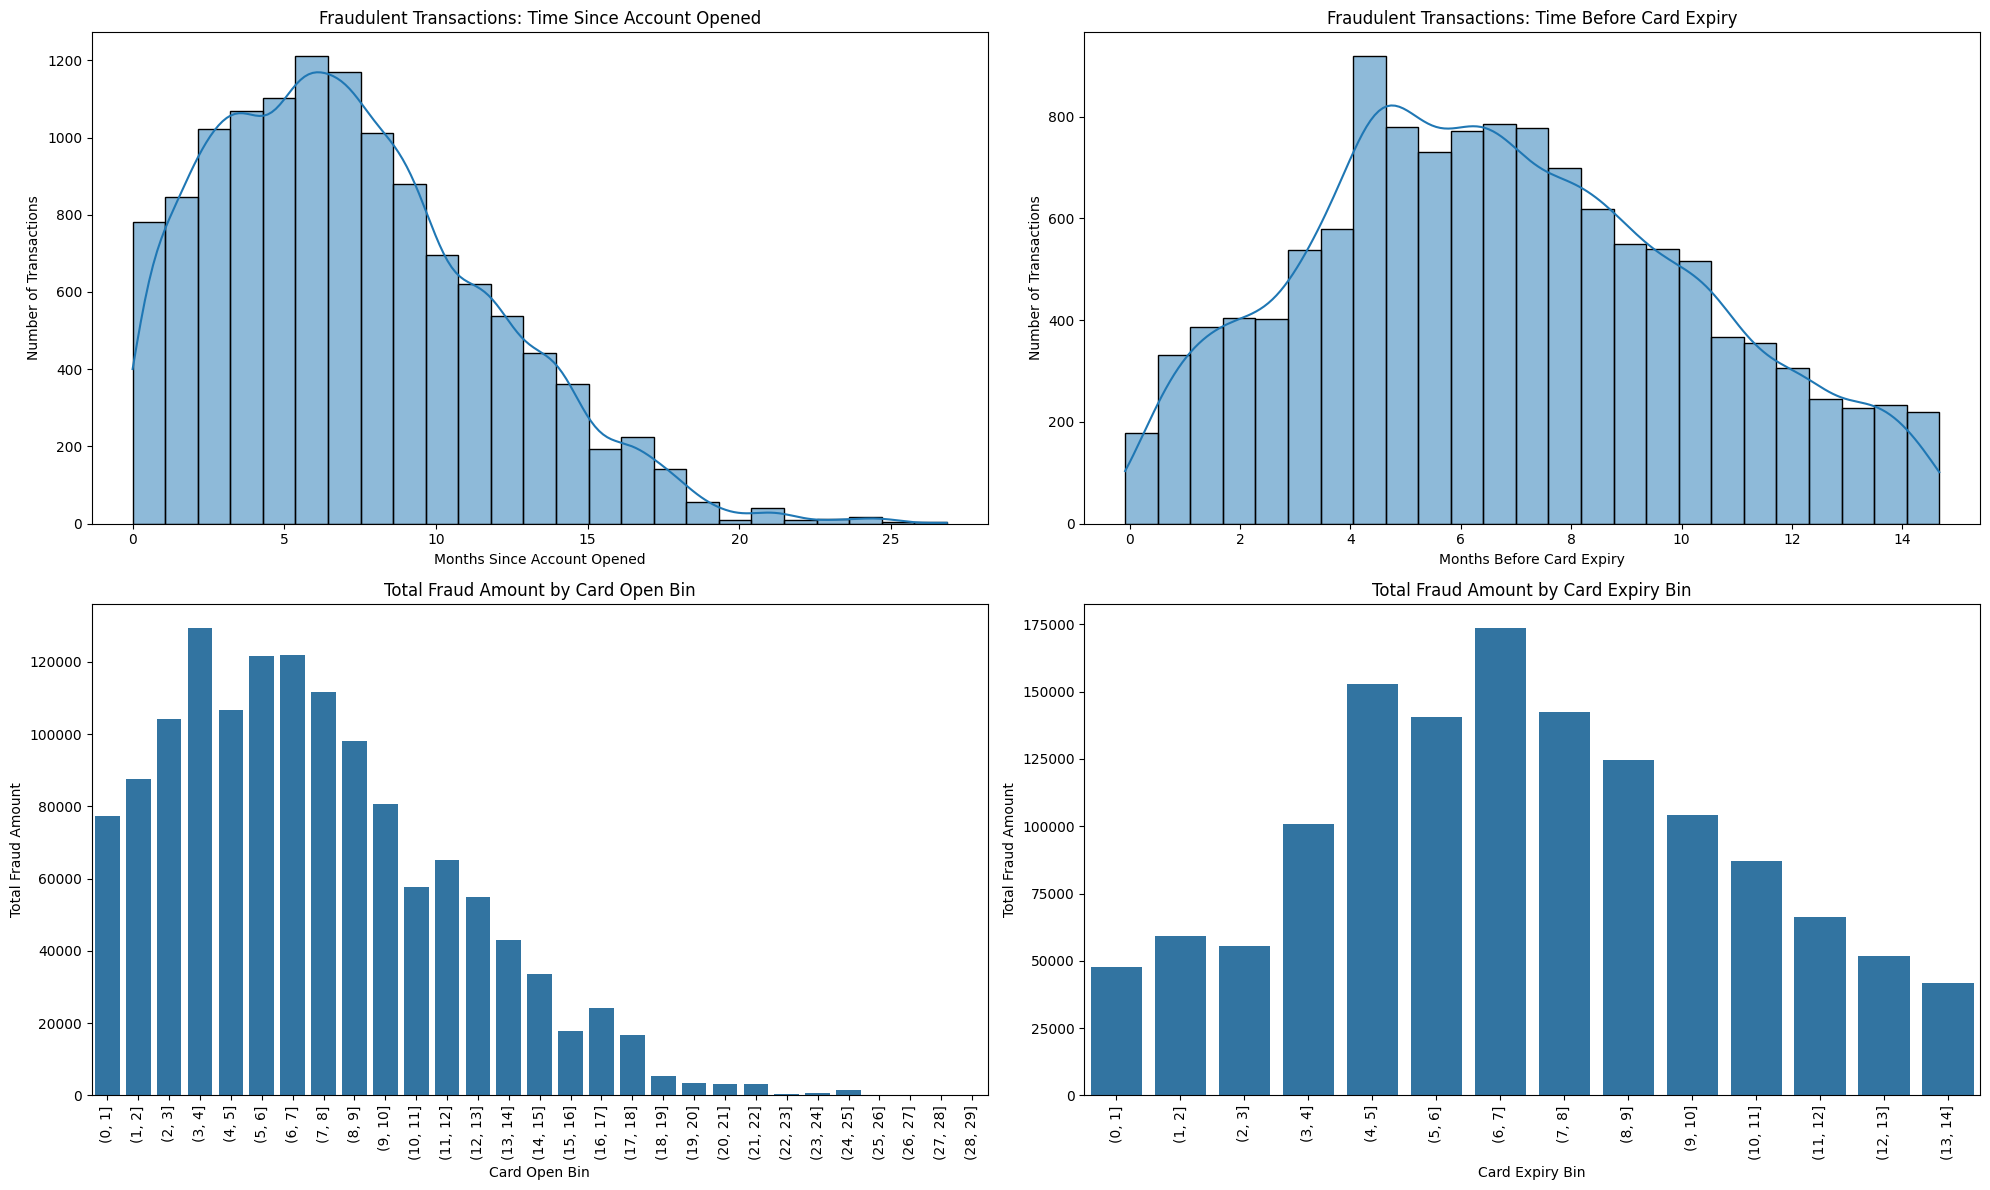

In [66]:
final_df['open_bin'] = pd.cut(final_df['transaction_since_acct_open'], bins=range(0, 30, 1))
final_df['expire_bin'] = pd.cut(final_df['transaction_before_expires'], bins=range(0, 15, 1))

fig, ax = plt.subplots(2,2, figsize = (20,12))

sns.histplot(data=final_df[final_df.fraud==1], x='transaction_since_acct_open', bins=25, kde=True, ax=ax[0,0])
ax[0,0].set_title('Fraudulent Transactions: Time Since Account Opened')
ax[0,0].set_xlabel('Months Since Account Opened')
ax[0,0].set_ylabel('Number of Transactions')

sns.histplot(data=final_df[final_df.fraud==1], x='transaction_before_expires', bins=25, kde=True, ax=ax[0,1])
ax[0,1].set_title('Fraudulent Transactions: Time Before Card Expiry')
ax[0,1].set_xlabel('Months Before Card Expiry')
ax[0,1].set_ylabel('Number of Transactions')

sns.barplot(data=final_df[final_df.fraud==1][['open_bin', 'amount']].groupby(['open_bin']).sum(), x='open_bin', y='amount',ax=ax[1,0])
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=90)
ax[1,0].set_title('Total Fraud Amount by Card Open Bin')
ax[1,0].set_xlabel('Card Open Bin')
ax[1,0].set_ylabel('Total Fraud Amount')

sns.barplot(data=final_df[final_df.fraud==1][['expire_bin', 'amount']].groupby(['expire_bin']).sum(), x='expire_bin', y='amount',ax=ax[1,1])
ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=90)
ax[1,1].set_title('Total Fraud Amount by Card Expiry Bin')
ax[1,1].set_xlabel('Card Expiry Bin')
ax[1,1].set_ylabel('Total Fraud Amount')

plt.tight_layout()
plt.show()

Accounts 3–8 months old and cards 6–8 months from expiry are high-risk segments.

##### Transaction Amount

In [67]:
final_df.groupby('fraud')['amount'].describe()


,count,mean,std,min,25%,50%,75%,max
fraud,,,,,,,,
0,6186719.0,42.816224,81.074271,-500.0,8.92,28.94,63.500,6613.44
1,12459.0,110.330694,215.734186,-500.0,17.69,69.15,148.505,4978.45


Fraud transaction are significantly higher both average and median values show over 2x difference.

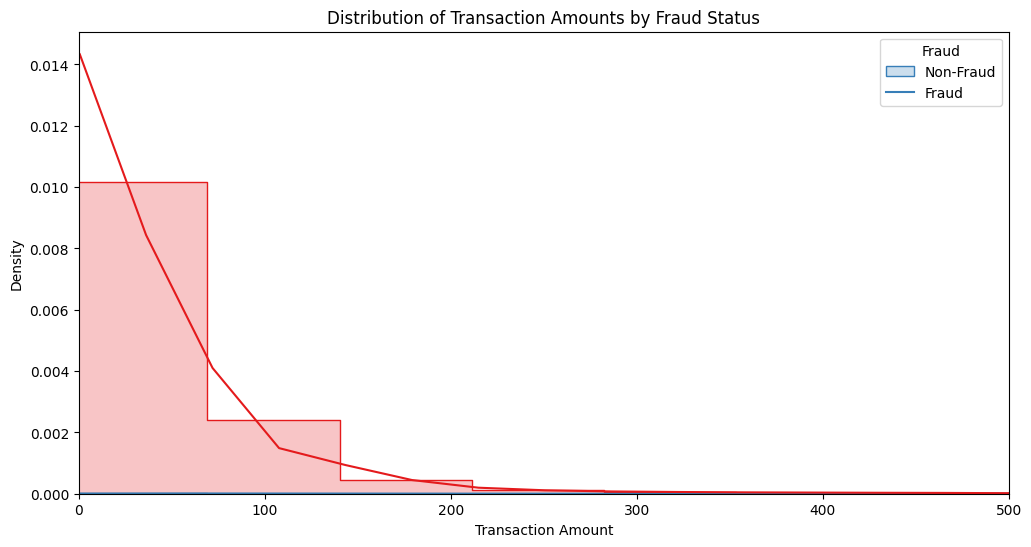

In [68]:
plt.figure(figsize=(12,6))
sns.histplot(data=final_df, x='amount', hue='fraud', bins=100, kde=True, stat='density', element='step', palette='Set1')
plt.xlim(0, 500)  # Adjust based on your distribution tail
plt.title("Distribution of Transaction Amounts by Fraud Status")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.legend(title="Fraud", labels=["Non-Fraud", "Fraud"])
plt.show()


Fraud transactions are heavily concentrated in low amounts, with some high-value outliers, while non-fraud transactions are more evenly distributed across higher amounts.

C:\Users\yashj\AppData\Local\Temp\ipykernel_15096\2926578006.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=final_df, x='fraud', y='amount', palette='Set2', inner='quartile')


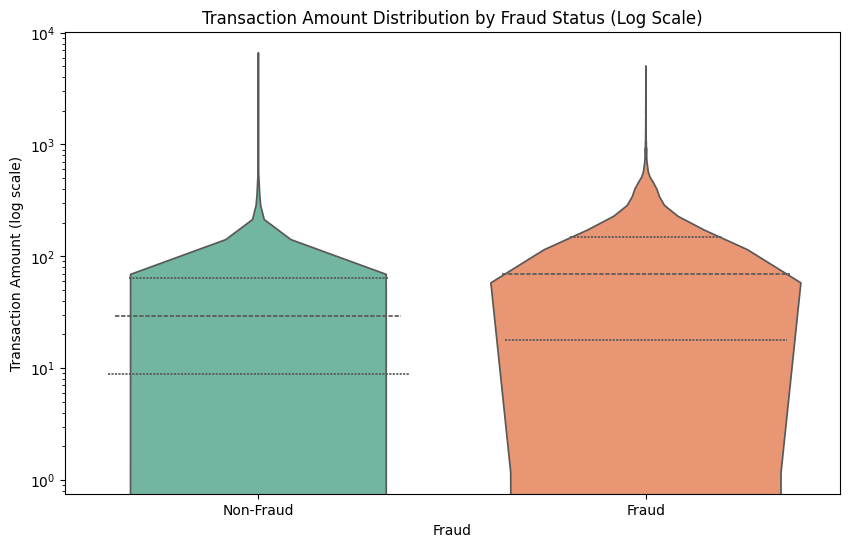

In [69]:
plt.figure(figsize=(10,6))

sns.violinplot(data=final_df, x='fraud', y='amount', palette='Set2', inner='quartile')
plt.yscale('log')  # Shows spread more clearly when data is skewed
plt.title("Transaction Amount Distribution by Fraud Status (Log Scale)")
plt.xlabel("Fraud")
plt.ylabel("Transaction Amount (log scale)")
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()


* Fraudulent transactions tend to involve larger amounts, mostly between 10–1,000 with a median around 100, while non-fraud transactions concentrate between 10–100 with a median near 31.6. Both distributions are right-skewed, featuring many small transactions and a long tail of larger amounts.
* There is substantial overlap in low-to-mid transaction values, meaning transaction amount is a useful but imperfect predictor for distinguishing fraud from non-fraud.

##### Errors

In [70]:
final_df.error.value_counts()

error
Insufficient Balance                                   60905
Bad PIN                                                14902
Technical Glitch                                       12360
Bad Card Number                                         3620
Bad CVV                                                 2898
Bad Expiration                                          2873
Bad Zipcode                                              515
Bad PIN,Insufficient Balance                             139
Insufficient Balance,Technical Glitch                    125
Bad PIN,Technical Glitch                                  37
Bad Card Number,Insufficient Balance                      33
Bad CVV,Insufficient Balance                              29
Bad Expiration,Insufficient Balance                       27
Bad Card Number,Bad Expiration                            21
Bad Card Number,Bad CVV                                   19
Bad Expiration,Bad CVV                                    13
Bad Expiration,Tec

In [71]:
final_df[final_df.fraud==1].error.value_counts()

error
Insufficient Balance                    154
Bad CVV                                 125
Bad PIN                                 102
Bad Card Number                          57
Bad Expiration                           50
Technical Glitch                         30
Bad CVV,Insufficient Balance              2
Bad Card Number,Insufficient Balance      1
Bad CVV,Technical Glitch                  1
Bad PIN,Insufficient Balance              1
Name: count, dtype: int64

##### MCC Codes

In [72]:
final_df.Description.value_counts()

Description
Grocery Stores, Supermarkets               742035
Miscellaneous Food Stores                  680435
Service Stations                           662743
Eating Places and Restaurants              465566
Drug Stores and Pharmacies                 359865
                                            ...  
Bolt, Nut, Screw, Rivet Manufacturing         176
Floor Covering Stores                         163
Miscellaneous Fabricated Metal Products       161
Household Appliance Stores                    157
Music Stores - Musical Instruments            155
Name: count, Length: 108, dtype: int64

In [73]:
final_df[final_df.fraud==1].Description.value_counts()

Description
Department Stores                    2108
Wholesale Clubs                       932
Discount Stores                       785
Money Transfer                        663
Drug Stores and Pharmacies            457
                                     ... 
Cleaning and Maintenance Services       4
Household Appliance Stores              4
Chiropractors                           2
Medical Services                        2
Podiatrists                             1
Name: count, Length: 96, dtype: int64

##### Merchant City and Merchant State along with Years

In [74]:
final_df[final_df.fraud==1].merchant_city.value_counts().head(5)

merchant_city
ONLINE            8182
Rome              2889
Port au Prince     251
Strasburg          137
Marion              16
Name: count, dtype: int64

In [75]:
final_df[final_df.fraud==1].merchant_state.value_counts().head(5)

merchant_state
Italy    2889
Haiti     251
OH        225
CA        127
TX         76
Name: count, dtype: int64

* Online transactions dominate fraud attempts, aligning with common digital fraud trends.
* Italy (especially Rome) may represent a testing or target area for fraudulent activity—possibly due to weak merchant validation or high-volume platforms.
* Location-based risk scoring should assign high risk to transactions with Italy.


In [76]:
final_df[final_df.merchant_state=='Italy'].fraud.mean()

np.float64(0.7236973947895792)

In [77]:
final_df[final_df.fraud==1].merchant_id.value_counts()

merchant_id
60569    722
27092    663
48919    311
99370    285
76639    266
        ... 
29086      1
18910      1
84684      1
22430      1
53330      1
Name: count, Length: 1086, dtype: int64

In [78]:
final_df[final_df.merchant_state=='Italy'].Description.value_counts()

Description
Department Stores                                    668
Grocery Stores, Supermarkets                         437
Service Stations                                     342
Miscellaneous Food Stores                            285
Eating Places and Restaurants                        238
Discount Stores                                      219
Drug Stores and Pharmacies                           173
Family Clothing Stores                               144
Taxicabs and Limousines                              125
Fast Food Restaurants                                 98
Non-Precious Metal Services                           93
Semiconductors and Related Devices                    88
Lumber and Building Materials                         85
Computers, Computer Peripheral Equipment              83
Industrial Equipment and Supplies                     82
Non-Ferrous Metal Foundries                           81
Precious Stones and Metals                            81
Furniture, Home Fur

In [79]:
final_df[(final_df.merchant_state=='Italy') & (final_df.fraud==1)].Description.value_counts()

Description
Department Stores                                    651
Grocery Stores, Supermarkets                         270
Discount Stores                                      213
Service Stations                                     154
Drug Stores and Pharmacies                           141
Family Clothing Stores                               138
Miscellaneous Food Stores                            123
Taxicabs and Limousines                               97
Computers, Computer Peripheral Equipment              83
Precious Stones and Metals                            81
Lumber and Building Materials                         80
Furniture, Home Furnishings, and Equipment Stores     79
Antique Shops                                         62
Eating Places and Restaurants                         58
Industrial Equipment and Supplies                     58
Passenger Railways                                    58
Drinking Places (Alcoholic Beverages)                 54
Non-Precious Metal 

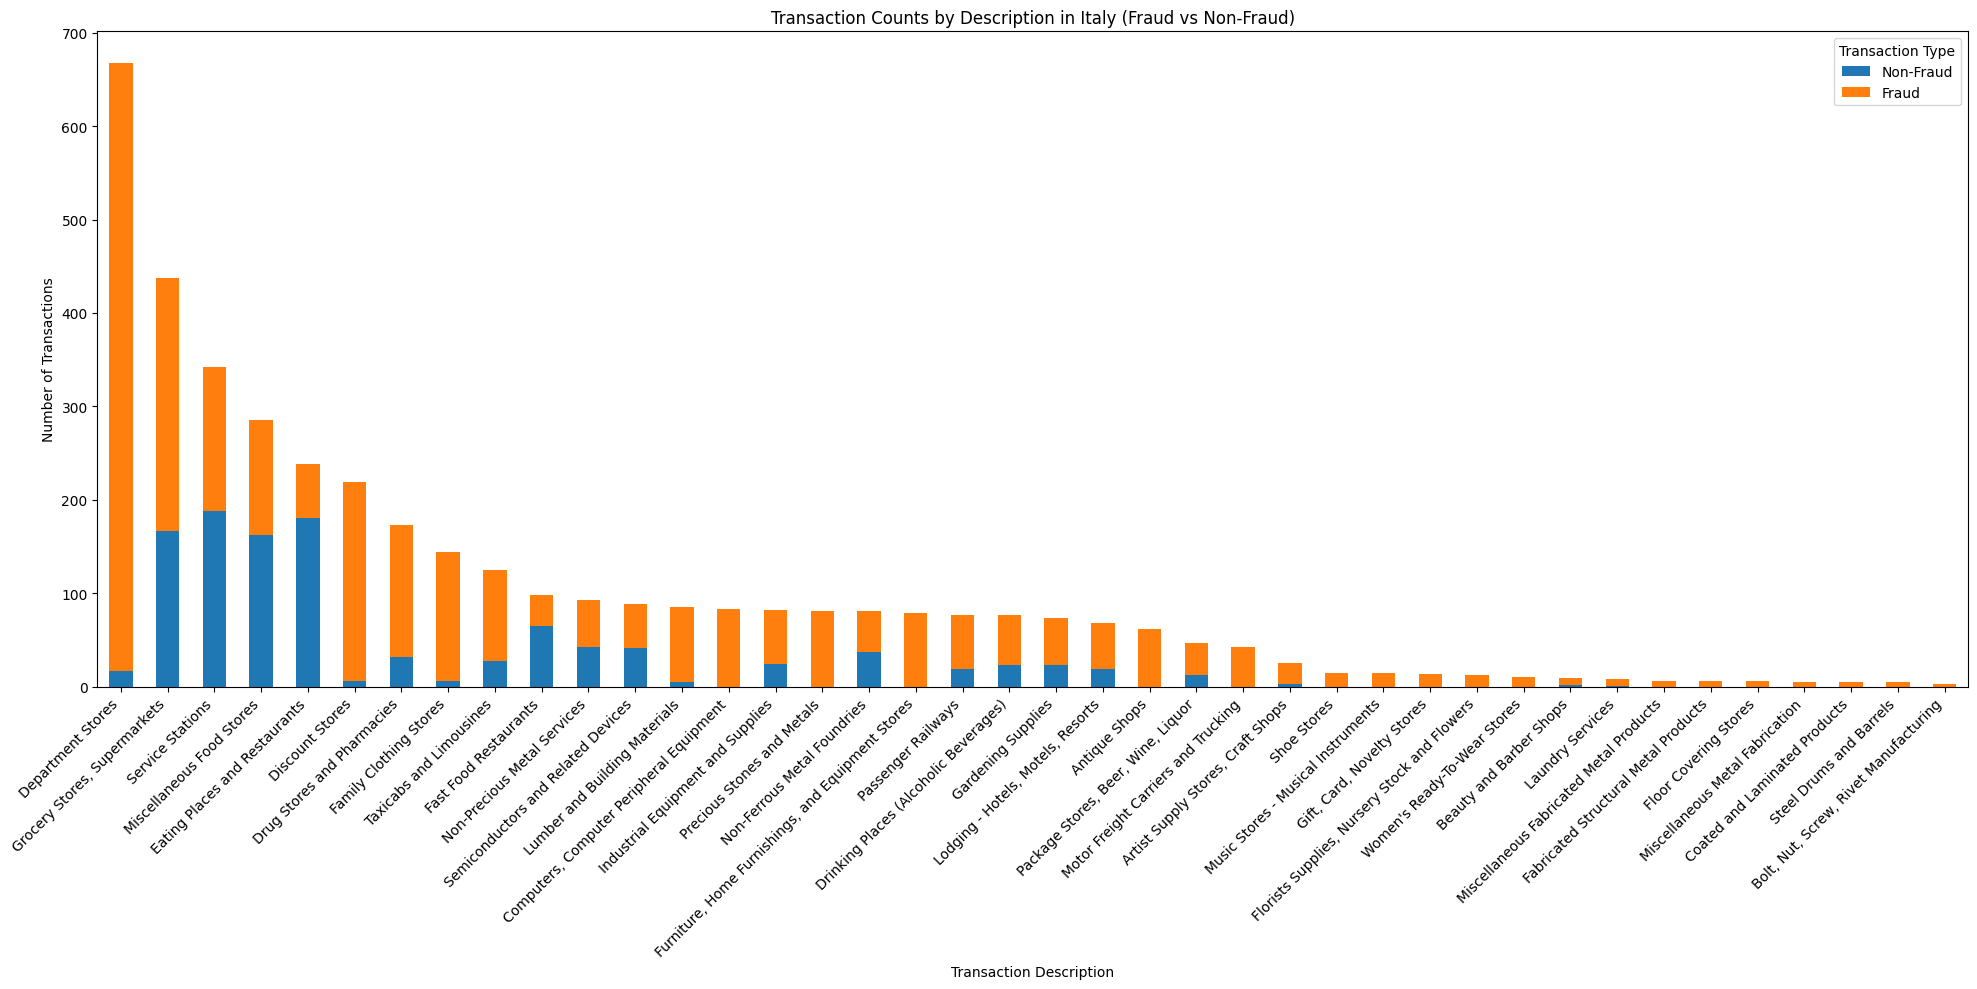

In [80]:
all_counts = final_df[final_df.merchant_state == 'Italy'].Description.value_counts()
fraud_counts = final_df[(final_df.merchant_state == 'Italy') & (final_df.fraud == 1)].Description.value_counts()
df_counts = pd.DataFrame({'All': all_counts, 'Fraud': fraud_counts}).fillna(0)
df_counts['Non-Fraud'] = df_counts['All'] - df_counts['Fraud']
df_counts = df_counts.sort_values(by='All', ascending=False)

ax = df_counts[['Non-Fraud', 'Fraud']].plot(kind='bar', stacked=True, figsize=(20,10))
plt.title('Transaction Counts by Description in Italy (Fraud vs Non-Fraud)')
plt.xlabel('Transaction Description')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Transaction Type')
plt.tight_layout()
plt.show()


* Department and discount stores face overwhelmingly high fraud rates, while restaurants and food-related businesses have significantly lower fraud.
* High-tech and high-value categories show notably high fraud, suggesting use in laundering or synthetic fraud schemes.

In [81]:
final_df[(final_df.merchant_state == 'Italy') & (final_df.fraud == 1)].groupby(['year', 'month'])['amount'].agg(
        mean_amount='mean',
        max_amount='max',
        min_amount='min',
        total_amount='sum',
        count='count'
    ).reset_index()

,year,month,mean_amount,max_amount,min_amount,total_amount,count
0,2018,1,109.432857,1343.48,-345.00,11490.45,105
1,2018,2,94.369000,826.21,0.00,11324.28,120
2,2018,3,75.838491,754.53,-366.00,12058.32,159
3,2018,4,65.116127,892.57,-484.00,11265.09,173
4,2018,5,86.445521,526.70,-238.00,8298.77,96
5,2018,6,78.558111,926.60,-94.00,7070.23,90
6,2018,7,76.485789,588.78,-380.00,7266.15,95
7,2018,8,64.007535,566.11,-221.00,9089.07,142
8,2018,9,82.868155,878.96,-386.00,13921.85,168
9,2018,10,75.525714,695.64,-351.00,9516.24,126


##### Debt to Income Ratio

In [82]:
final_df['debt_income_ratio'] = final_df['total_debt']/final_df['yearly_income']

C:\Users\yashj\AppData\Local\Temp\ipykernel_15096\2388389705.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(data=final_df[final_df.fraud==1][['debt_bin', 'amount']].groupby(['debt_bin']).sum(), x='debt_bin', y='amount',ax=ax[1,0])
C:\Users\yashj\AppData\Local\Temp\ipykernel_15096\2388389705.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(data=final_df[final_df.fraud==1][['debt_bin', 'amount']].groupby(['debt_bin']).mean(), x='debt_bin', y='amount',ax=ax[1,1])


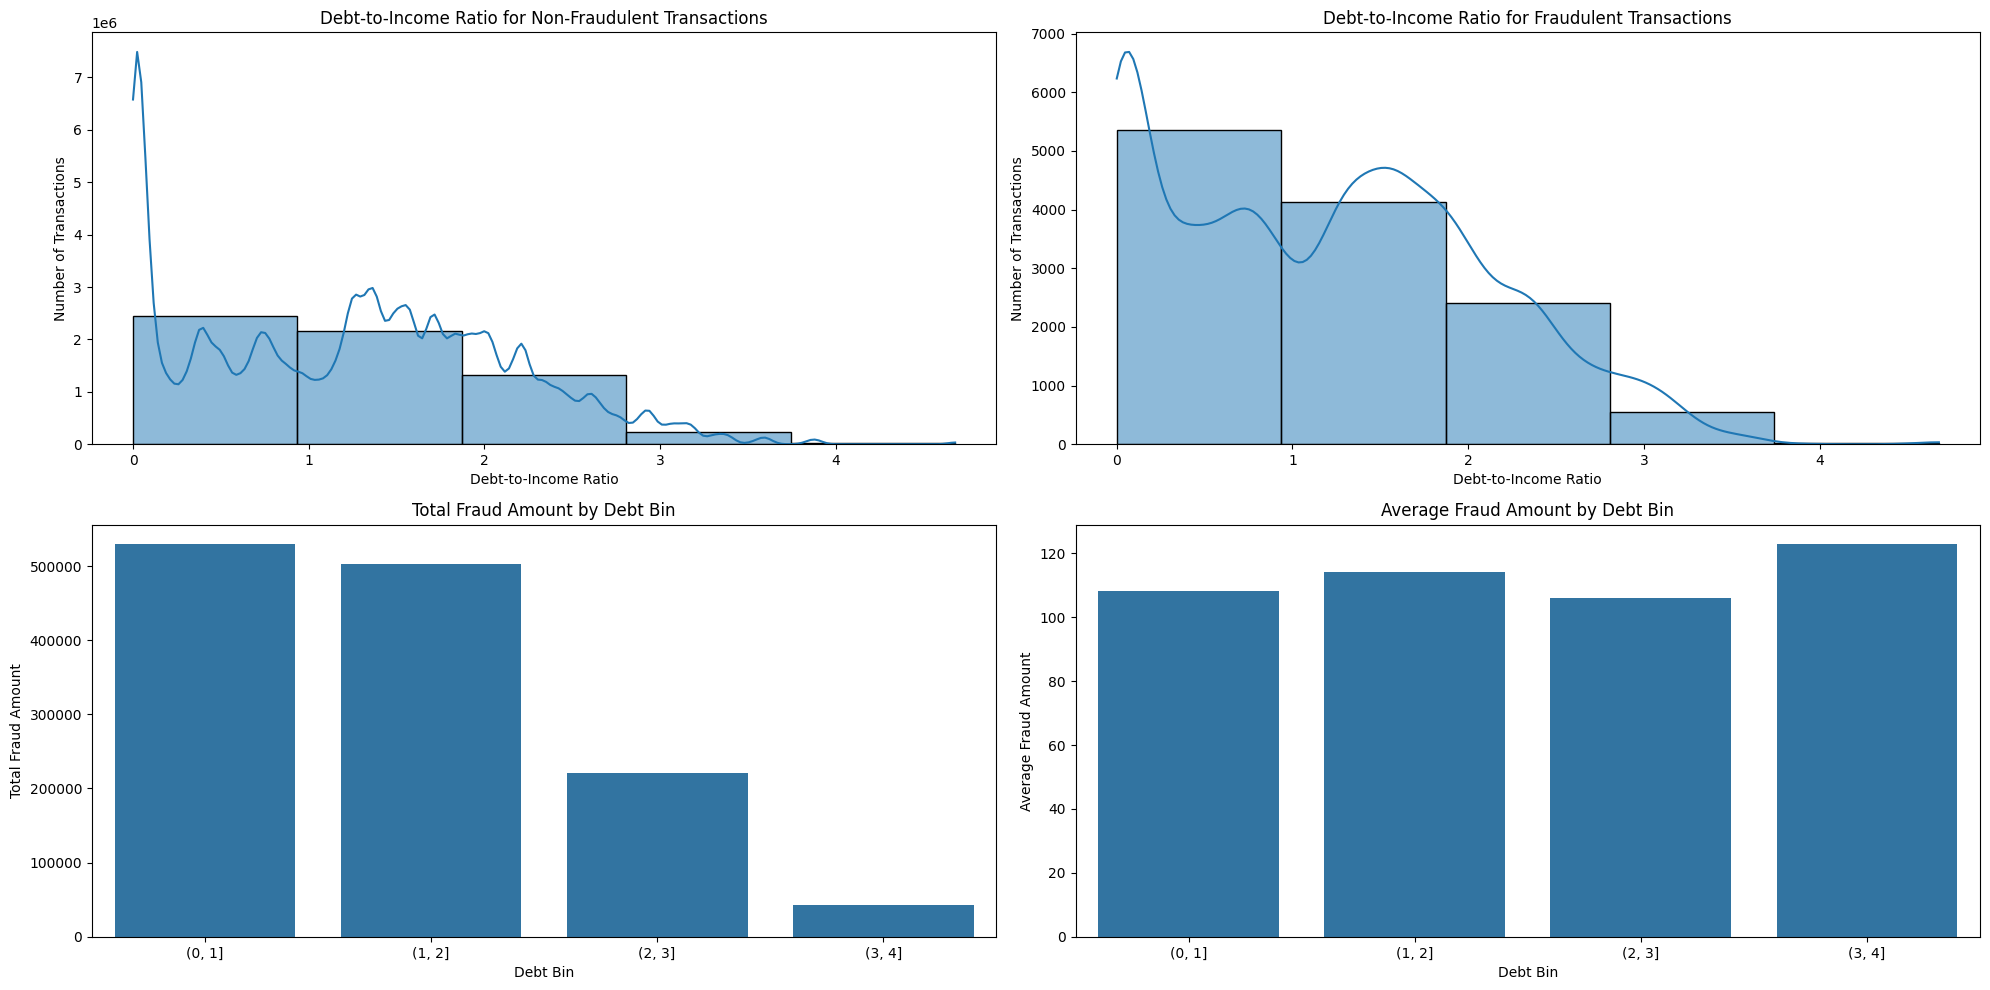

In [83]:
fig, ax = plt.subplots(2,2, figsize = (20,10))

sns.histplot(data=final_df[final_df.fraud==0], x='debt_income_ratio', bins=5, kde=True, ax=ax[0,0])
ax[0,0].set_title('Debt-to-Income Ratio for Non-Fraudulent Transactions')
ax[0,0].set_xlabel('Debt-to-Income Ratio')
ax[0,0].set_ylabel('Number of Transactions')

sns.histplot(data=final_df[final_df.fraud==1], x='debt_income_ratio', bins=5, kde=True, ax=ax[0,1])
ax[0,1].set_title('Debt-to-Income Ratio for Fraudulent Transactions')
ax[0,1].set_xlabel('Debt-to-Income Ratio')
ax[0,1].set_ylabel('Number of Transactions')

final_df['debt_bin'] = pd.cut(final_df['debt_income_ratio'], bins=range(0, 5, 1))

sns.barplot(data=final_df[final_df.fraud==1][['debt_bin', 'amount']].groupby(['debt_bin']).sum(), x='debt_bin', y='amount',ax=ax[1,0])
ax[1,0].set_title('Total Fraud Amount by Debt Bin')
ax[1,0].set_xlabel('Debt Bin')
ax[1,0].set_ylabel('Total Fraud Amount')

sns.barplot(data=final_df[final_df.fraud==1][['debt_bin', 'amount']].groupby(['debt_bin']).mean(), x='debt_bin', y='amount',ax=ax[1,1])
ax[1,1].set_title('Average Fraud Amount by Debt Bin')
ax[1,1].set_xlabel('Debt Bin')
ax[1,1].set_ylabel('Average Fraud Amount')

plt.tight_layout()
plt.show()

Fraud is slightly more common in higher transaction amounts, while debt-to-income ratio shows no meaningful relationship with fraud, indicating the need to focus on transaction size and other factors for better fraud detection.

### Time to Retirement (Current Age and Retirement Age)

In [84]:
final_df['time_to_retirement'] = final_df.retirement_age - final_df.current_age

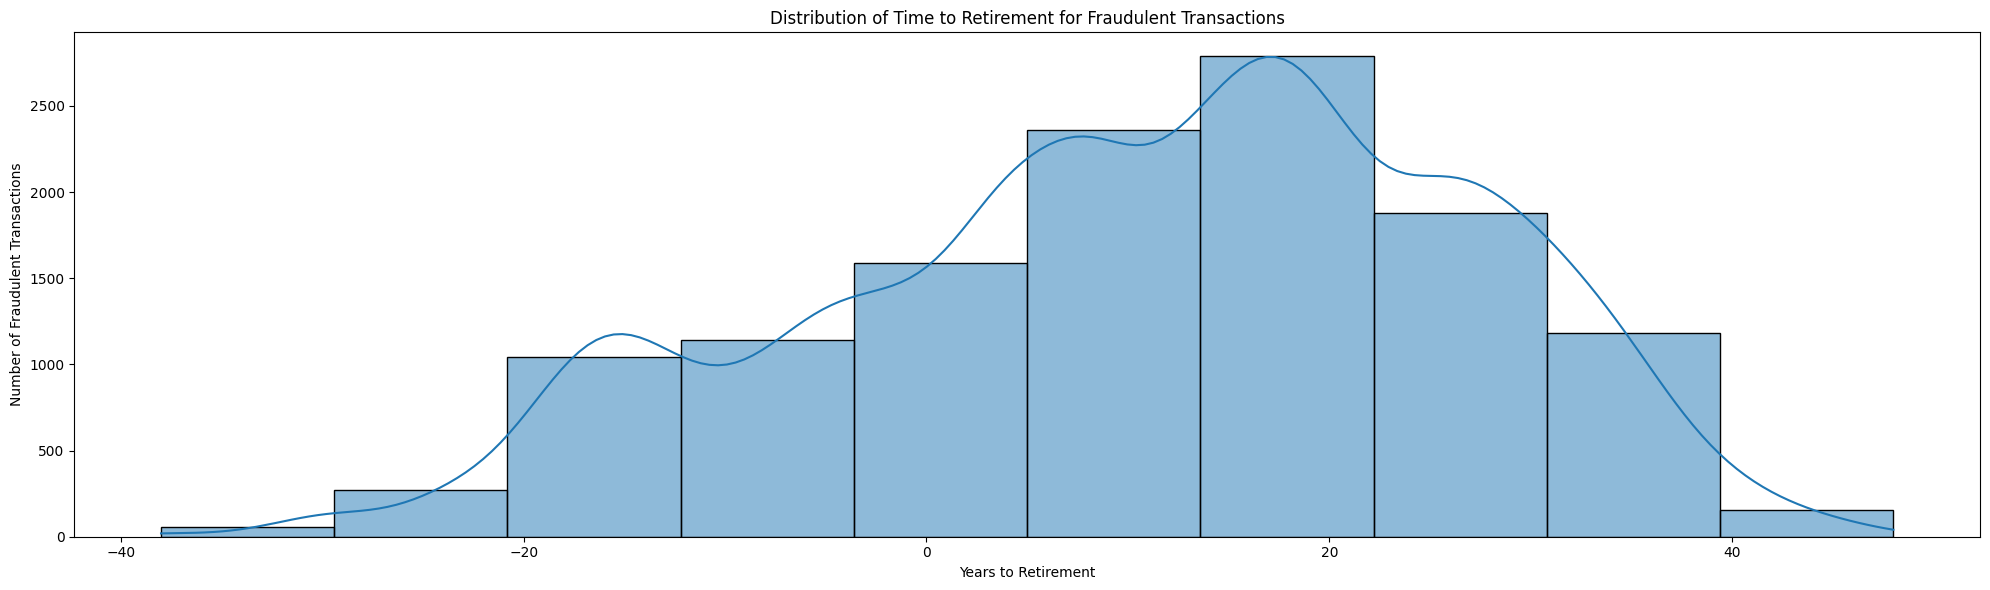

In [85]:
plt.figure(figsize=(20,6))
sns.histplot(data=final_df[final_df.fraud==1], x='time_to_retirement', bins =10, kde=True)
plt.title('Distribution of Time to Retirement for Fraudulent Transactions')
plt.xlabel('Years to Retirement')
plt.ylabel('Number of Fraudulent Transactions')
plt.tight_layout()
plt.show()

* Fraudulent transactions peak around 15–20 years before retirement, indicating higher risk during this period.
* Noticeable fraud activity also occurs after retirement, suggesting risk persists beyond the workforce.

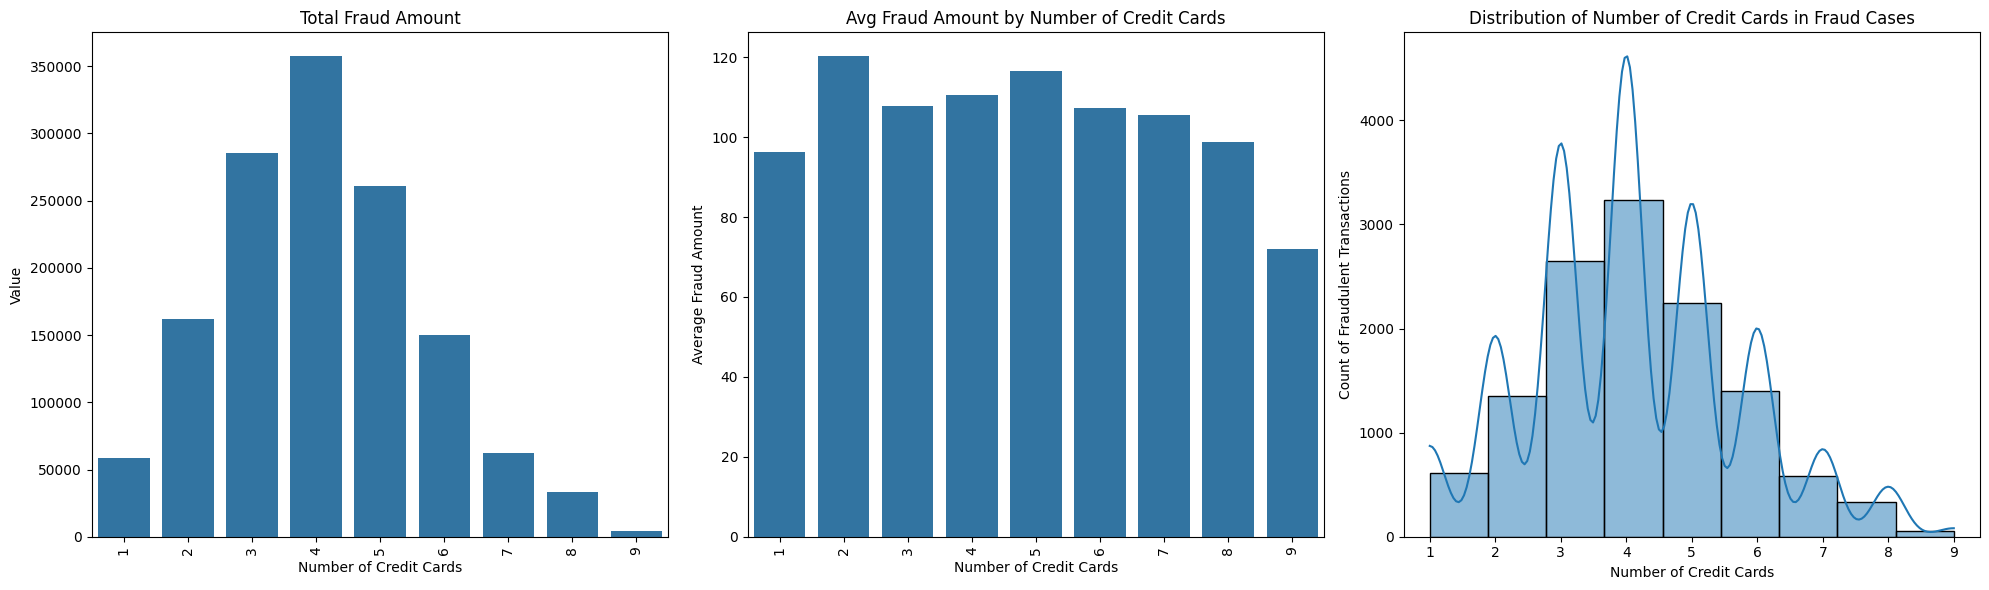

In [86]:
fig, ax = plt.subplots(1,3, figsize = (20,6))
sns.barplot(data=final_df[final_df.fraud==1][['num_credit_cards', 'amount']].groupby(['num_credit_cards']).sum(), x='num_credit_cards', y='amount',ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_title('Total Fraud Amount')
ax[0].set_xlabel('Number of Credit Cards')
ax[0].set_ylabel('Value')

sns.barplot(data=final_df[final_df.fraud==1][['num_credit_cards', 'amount']].groupby(['num_credit_cards']).mean(), x='num_credit_cards', y='amount',ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_title('Avg Fraud Amount by Number of Credit Cards')
ax[1].set_xlabel('Number of Credit Cards')
ax[1].set_ylabel('Average Fraud Amount')

sns.histplot(data=final_df[final_df.fraud==1], x='num_credit_cards', bins =9, kde=True, ax=ax[2])
ax[2].set_title('Distribution of Number of Credit Cards in Fraud Cases')
ax[2].set_xlabel('Number of Credit Cards')
ax[2].set_ylabel('Count of Fraudulent Transactions')

plt.tight_layout()
plt.show()

* Individuals with 4 credit cards are linked to the highest total fraud amount, as well as the highest count of fraud cases.
* Average fraud amount peaks around 2–5 credit cards, but drops notably for individuals with 9 or more cards.

In [87]:
final_df['ones'] = 1
final_df['update_amt'] = np.where(final_df.neg_amount=='Yes',final_df['amount']*-1,final_df.amount)
final_df['cumsum_user'] = final_df.groupby(['client_id']).update_amt.cumsum()
final_df['cumsum_card'] = final_df.groupby(['card_id']).update_amt.cumsum()
final_df['transaction_number_user'] = final_df.groupby(['client_id']).ones.cumsum()
final_df['transaction_number_card'] = final_df.groupby(['card_id']).ones.cumsum()

In [88]:
client_card_df = final_df[['client_id','card_id','fraud','update_amt']].groupby(['client_id','card_id','fraud']).agg(
        mean_amount=('update_amt', 'mean'),
        max_amount=('update_amt', 'max'),
        min_amount=('update_amt', 'min'),
        total_amount=('update_amt', 'sum'),
        count=('update_amt', 'count')
    ).reset_index()
client_card_df.head(10)

,client_id,card_id,fraud,mean_amount,max_amount,min_amount,total_amount,count
0,0,1271,0,46.906273,577.46,0.81,144612.04,3083
1,0,1271,1,30.260000,45.48,15.04,60.52,2
2,0,4639,0,79.719669,1128.47,0.78,228795.45,2870
3,0,4639,1,70.697500,129.40,5.13,282.79,4
4,1,3682,0,40.928381,488.00,0.54,31351.14,766
5,1,4400,0,29.213369,634.41,0.27,46390.83,1588
6,1,4400,1,174.560000,286.39,2.20,523.68,3
7,1,4652,0,41.112662,937.15,0.97,95915.84,2333
8,1,4652,1,116.164000,367.00,9.04,1161.64,10
9,2,2576,0,30.318322,349.03,0.32,54572.98,1800


In [89]:
client_fraud_status = client_card_df.groupby('client_id')['fraud'].nunique()
single_clients = client_fraud_status[client_fraud_status == 1].index
fraud_only_clients = client_card_df[(client_card_df['client_id'].isin(single_clients)) & (client_card_df['fraud'] == 1)]['client_id'].unique()
fraud_only_clients

array([], dtype=int64)

In [90]:
no_fraud_only_clients = client_card_df[(client_card_df['client_id'].isin(single_clients)) & (client_card_df['fraud'] == 0)]['client_id'].unique()
no_fraud_only_clients

array([  33,   34,   57,   65,   87,   89,   92,  147,  170,  216,  242,
        361,  368,  400,  432,  452,  473,  483,  628,  648,  660,  734,
        747,  751,  846,  895,  906, 1003, 1047, 1053, 1164, 1225, 1301,
       1335, 1530, 1589, 1662, 1664, 1703, 1752, 1818, 1871, 1874, 1988])

In [91]:
# Step 1: Aggregate fraud and total data
grouped = client_card_df.groupby(['client_id', 'card_id', 'fraud']).agg(
    fraud_count=('count', 'sum'),
    fraud_amount=('total_amount', 'sum')
).reset_index()

# Step 2: Pivot to get fraud and non-fraud side by side
pivoted = grouped.pivot(index=['client_id', 'card_id'], columns='fraud', values=['fraud_count', 'fraud_amount'])
pivoted.columns = ['count_nonfraud', 'count_fraud', 'amount_nonfraud', 'amount_fraud']
pivoted = pivoted.fillna(0).reset_index()

# Step 3: Calculate percentages
pivoted['fraud_count_pct'] = round(100 * pivoted['count_fraud'] / (pivoted['count_fraud'] + pivoted['count_nonfraud']),2)
pivoted['fraud_amount_pct'] = round(100 * pivoted['amount_fraud'] / (pivoted['amount_fraud'] + pivoted['amount_nonfraud']),2)


In [92]:
pivoted.sort_values('fraud_count_pct').tail(20)

,client_id,card_id,count_nonfraud,count_fraud,amount_nonfraud,amount_fraud,fraud_count_pct,fraud_amount_pct
2229,1128,4316,324.0,14.0,18877.73,2728.44,4.14,12.63
1427,712,2773,91.0,4.0,2932.73,197.13,4.21,6.30
3166,1571,6109,272.0,12.0,22479.34,871.19,4.23,3.73
2538,1267,4299,338.0,15.0,7092.80,4507.32,4.25,38.86
1613,804,2553,221.0,10.0,5775.46,941.46,4.33,14.02
3522,1746,3754,277.0,13.0,6788.21,5125.89,4.48,43.02
1012,496,5806,525.0,25.0,40447.16,1953.57,4.55,4.61
3677,1820,5201,357.0,17.0,19682.82,2127.90,4.55,9.76
2425,1223,1042,178.0,9.0,32814.56,693.37,4.81,2.07
1517,754,2219,176.0,9.0,6164.70,680.40,4.86,9.94


In [93]:
pivoted.sort_values('fraud_amount_pct').tail(20)

,client_id,card_id,count_nonfraud,count_fraud,amount_nonfraud,amount_fraud,fraud_count_pct,fraud_amount_pct
568,260,5119,564.0,3.0,15353.47,2649.18,0.53,14.72
941,462,1259,163.0,5.0,2483.29,451.11,2.98,15.37
93,46,1167,627.0,9.0,16128.41,3199.31,1.42,16.55
3410,1694,5032,814.0,19.0,14527.10,2953.21,2.28,16.89
1680,840,4992,182.0,5.0,5872.83,1199.46,2.67,16.96
3920,1942,246,1135.0,5.0,5899.88,1254.38,0.44,17.53
2607,1302,3972,41.0,3.0,345.19,82.17,6.82,19.23
2015,1016,5883,332.0,8.0,6381.20,1992.37,2.35,23.79
2178,1102,3952,970.0,26.0,13890.67,4570.58,2.61,24.76
3899,1928,2442,634.0,19.0,8498.09,2828.68,2.91,24.97


In [94]:
def compute_risk_score(row):
    fraud_amt_threshold = pivoted[pivoted['fraud_count_pct']>0]['amount_fraud'].quantile(0.75)
    fraud_cnt_pct_threshold = pivoted[pivoted['fraud_count_pct']>0]['fraud_count_pct'].quantile(0.75)
    fraud_amt_pct_threshold = pivoted[pivoted['fraud_count_pct']>0]['fraud_amount_pct'].quantile(0.75)
    score = 0
    if row['fraud_count_pct'] > fraud_cnt_pct_threshold:
        score += 1
    if row['fraud_amount_pct'] > fraud_amt_pct_threshold:
        score += 1
    if row['amount_fraud'] > fraud_amt_threshold:
        score += 1
    return score

In [95]:
pivoted['risk_score'] = pivoted.apply(compute_risk_score, axis=1)

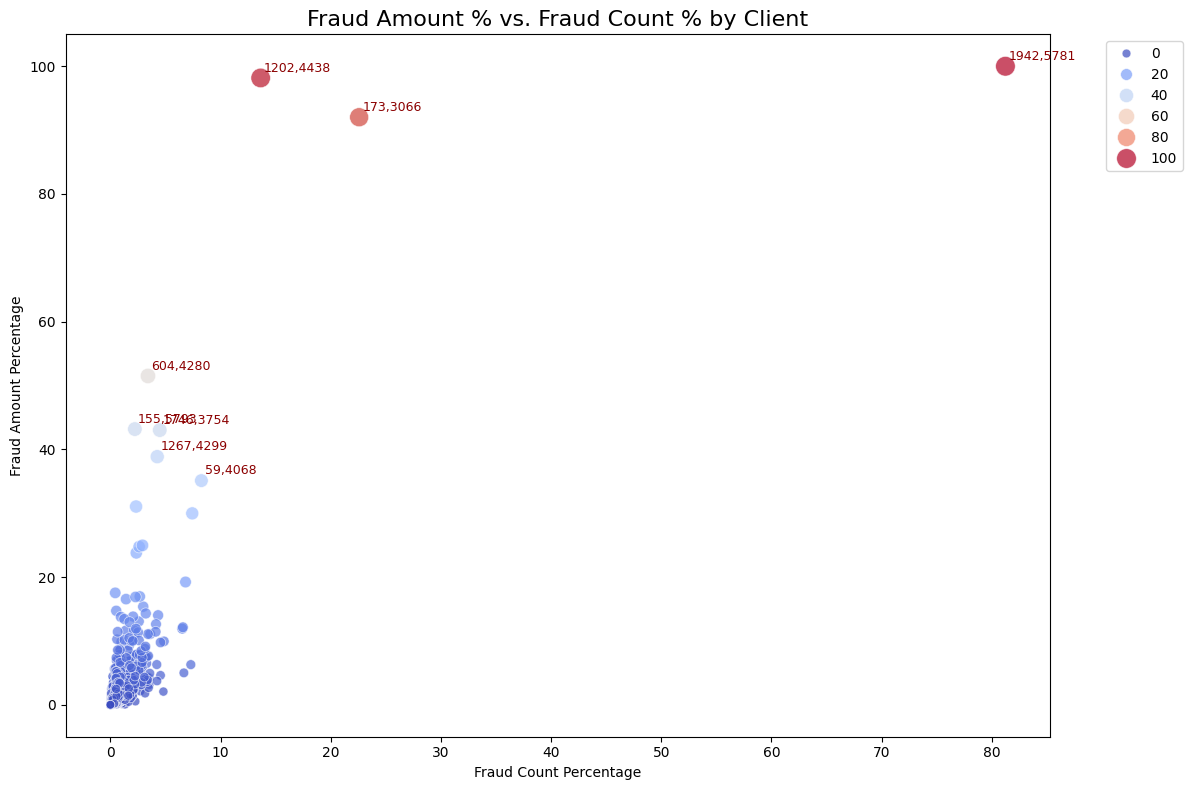

In [96]:
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot( data=pivoted, x="fraud_count_pct", y="fraud_amount_pct", hue="fraud_amount_pct", palette="coolwarm", size="fraud_amount_pct", sizes=(40, 200), alpha=0.7, edgecolor="w")

plt.title("Fraud Amount % vs. Fraud Count % by Client", fontsize=16)
plt.xlabel("Fraud Count Percentage")
plt.ylabel("Fraud Amount Percentage")

high_risk = pivoted[(pivoted["fraud_amount_pct"] > 35)]
for _, row in high_risk.iterrows():
    label = f"{int(row['client_id'])},{int(row['card_id'])}"
    plt.text(row["fraud_count_pct"] + 0.3, row["fraud_amount_pct"] + 1,
            label, fontsize=9, color='darkred')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()

* A small number of clients account for nearly 100% of both fraud amount and fraud count, indicating extreme concentration of fraudulent activity.
* Most clients have very low fraud percentages, clustering near the origin, suggesting fraud is highly skewed toward a few high-risk individuals.


In [97]:
final_df['fraud_trns_users'] = final_df.groupby(['client_id']).fraud.cumsum()
final_df['fraud_trns_card'] = final_df.groupby(['card_id']).fraud.cumsum()

In [98]:
final_df.groupby('fraud')[['cumsum_user']].describe().reset_index()

fraud cumsum_user                                                           \
              count           mean            std   min       25%        50%   
0     0   6186719.0  170050.784334  161238.071480   0.0  62271.57  129691.78   
1     1     12459.0  137090.017394  130212.365413  38.7  45834.93  112325.36   

                           
          75%         max  
0  225619.745  1658621.95  
1  185771.860  1338833.76

In [99]:
final_df.groupby('fraud')[['cumsum_card']].describe().reset_index()

fraud cumsum_card                                                         \
              count          mean           std   min        25%       50%   
0     0   6186719.0  72580.803775  92634.875689  0.00  18444.945  43844.18   
1     1     12459.0  48121.482283  59837.783491  4.24  11382.230  28736.52   

                          
         75%         max  
0  90769.920  1222206.37  
1  59601.085   644718.84

plots and analysis for above

In [100]:
final_df = final_df.merge(pivoted.rename(columns={'card_id': 'cc_id'})[['risk_score', 'cc_id']],how='left',left_on='card_id',right_on='cc_id')
final_df.drop('cc_id',inplace=True,axis =1)

In [101]:
final_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,transaction_id,fraud,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_year,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,Description,year,month,neg_amount,log_amount,day,day_name,is_weekend,day_type,hour,transaction_since_acct_open,transaction_before_expires,open_bin,expire_bin,debt_income_ratio,debt_bin,time_to_retirement,ones,update_amt,cumsum_user,cumsum_card,transaction_number_user,transaction_number_card,fraud_trns_users,fraud_trns_card,risk_score
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,7475327,0,Mastercard,Debit (Prepaid),2022-07-01,YES,2,55.0,2008-05-01,2008,30,67,1989,7,Female,23679.0,48277.0,110153.0,740,4,Miscellaneous Food Stores,2010,1,Yes,NaN,1,Friday,False,Weekday,0,1.667,12.500,"(1, 2]","(12.0, 13.0]",2.281687,"(2, 3]",37,1,77.00,77.00,77.00,1,1,0,0,2
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,7475328,0,Mastercard,Credit,2024-12-01,YES,1,9100.0,2005-09-01,2015,48,67,1971,6,Male,18076.0,36853.0,112139.0,834,5,Department Stores,2010,1,No,2.745346,1,Friday,False,Weekday,0,4.333,14.917,"(4, 5]",NaN,3.042873,"(3, 4]",19,1,14.57,14.57,14.57,1,1,0,0,0
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,7475329,0,Mastercard,Debit,2020-05-01,YES,1,14802.0,2006-01-01,2008,49,65,1970,4,Male,16894.0,34449.0,36540.0,686,3,Money Transfer,2010,1,No,4.394449,1,Friday,False,Weekday,0,4.000,10.333,"(3, 4]","(10.0, 11.0]",1.060698,"(1, 2]",16,1,80.00,80.00,80.00,1,1,0,0,0
3,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,7475332,0,Visa,Debit,2020-01-01,YES,1,19113.0,2009-07-01,2014,51,69,1968,5,Male,33529.0,68362.0,96182.0,711,2,Drinking Places (Alcoholic Beverages),2010,1,No,3.858833,1,Friday,False,Weekday,0,0.500,10.000,"(0, 1]","(9.0, 10.0]",1.406951,"(1, 2]",18,1,46.41,46.41,46.41,1,1,0,0,2
4,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464,5942,None,7475333,0,Mastercard,Debit (Prepaid),2014-03-01,YES,1,89.0,2008-01-01,2015,47,65,1972,12,Female,25537.0,52065.0,98613.0,828,5,Book Stores,2010,1,No,1.759581,1,Friday,False,Weekday,0,2.000,4.167,"(1, 2]","(4.0, 5.0]",1.894036,"(1, 2]",18,1,4.81,4.81,4.81,1,1,0,0,0


##### Converting objects to integers

In [102]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [103]:
final_df['card_brand']= label_encoder.fit_transform(final_df['card_brand'])
final_df['card_type']= label_encoder.fit_transform(final_df['card_type'])
final_df['transaction_mode']= label_encoder.fit_transform(final_df['transaction_mode'])
final_df['has_chip']= label_encoder.fit_transform(final_df['has_chip'])


In [104]:
final_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,transaction_id,fraud,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_year,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,Description,year,month,neg_amount,log_amount,day,day_name,is_weekend,day_type,hour,transaction_since_acct_open,transaction_before_expires,open_bin,expire_bin,debt_income_ratio,debt_bin,time_to_retirement,ones,update_amt,cumsum_user,cumsum_card,transaction_number_user,transaction_number_card,fraud_trns_users,fraud_trns_card,risk_score
0,2010-01-01 00:01:00,1556,2972,-77.00,2,59935,Beulah,ND,58523,5499,None,7475327,0,2,2,2022-07-01,1,2,55.0,2008-05-01,2008,30,67,1989,7,Female,23679.0,48277.0,110153.0,740,4,Miscellaneous Food Stores,2010,1,Yes,NaN,1,Friday,False,Weekday,0,1.667,12.500,"(1, 2]","(12.0, 13.0]",2.281687,"(2, 3]",37,1,77.00,77.00,77.00,1,1,0,0,2
1,2010-01-01 00:02:00,561,4575,14.57,2,67570,Bettendorf,IA,52722,5311,None,7475328,0,2,0,2024-12-01,1,1,9100.0,2005-09-01,2015,48,67,1971,6,Male,18076.0,36853.0,112139.0,834,5,Department Stores,2010,1,No,2.745346,1,Friday,False,Weekday,0,4.333,14.917,"(4, 5]",NaN,3.042873,"(3, 4]",19,1,14.57,14.57,14.57,1,1,0,0,0
2,2010-01-01 00:02:00,1129,102,80.00,2,27092,Vista,CA,92084,4829,None,7475329,0,2,1,2020-05-01,1,1,14802.0,2006-01-01,2008,49,65,1970,4,Male,16894.0,34449.0,36540.0,686,3,Money Transfer,2010,1,No,4.394449,1,Friday,False,Weekday,0,4.000,10.333,"(3, 4]","(10.0, 11.0]",1.060698,"(1, 2]",16,1,80.00,80.00,80.00,1,1,0,0,0
3,2010-01-01 00:06:00,848,3915,46.41,2,13051,Harwood,MD,20776,5813,None,7475332,0,3,1,2020-01-01,1,1,19113.0,2009-07-01,2014,51,69,1968,5,Male,33529.0,68362.0,96182.0,711,2,Drinking Places (Alcoholic Beverages),2010,1,No,3.858833,1,Friday,False,Weekday,0,0.500,10.000,"(0, 1]","(9.0, 10.0]",1.406951,"(1, 2]",18,1,46.41,46.41,46.41,1,1,0,0,2
4,2010-01-01 00:07:00,1807,165,4.81,2,20519,Bronx,NY,10464,5942,None,7475333,0,2,2,2014-03-01,1,1,89.0,2008-01-01,2015,47,65,1972,12,Female,25537.0,52065.0,98613.0,828,5,Book Stores,2010,1,No,1.759581,1,Friday,False,Weekday,0,2.000,4.167,"(1, 2]","(4.0, 5.0]",1.894036,"(1, 2]",18,1,4.81,4.81,4.81,1,1,0,0,0


In [105]:
final_df[['merchant_id','merchant_city','merchant_state','Description']].nunique()

merchant_id       57488
merchant_city     11505
merchant_state      188
Description         108
dtype: int64

In [106]:
final_df['merchant_state']= label_encoder.fit_transform(final_df['merchant_state'])
final_df['merchant_city']= label_encoder.fit_transform(final_df['merchant_city'])
final_df['Description']= label_encoder.fit_transform(final_df['Description'])
final_df['gender']= label_encoder.fit_transform(final_df['gender'])
final_df['error']= label_encoder.fit_transform(final_df['error'])
final_df['zip']= label_encoder.fit_transform(final_df['zip'])
final_df['open_bin']= label_encoder.fit_transform(final_df['open_bin'])
final_df['expire_bin']= label_encoder.fit_transform(final_df['expire_bin'])
final_df['debt_bin']= label_encoder.fit_transform(final_df['debt_bin'])
final_df['day_name']= label_encoder.fit_transform(final_df['day_name'])
final_df['is_weekend']= label_encoder.fit_transform(final_df['is_weekend'])


In [107]:
final_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,transaction_id,fraud,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_year,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,Description,year,month,neg_amount,log_amount,day,day_name,is_weekend,day_type,hour,transaction_since_acct_open,transaction_before_expires,open_bin,expire_bin,debt_income_ratio,debt_bin,time_to_retirement,ones,update_amt,cumsum_user,cumsum_card,transaction_number_user,transaction_number_card,fraud_trns_users,fraud_trns_card,risk_score
0,2010-01-01 00:01:00,1556,2972,-77.00,2,59935,763,109,13398,5499,22,7475327,0,2,2,2022-07-01,1,2,55.0,2008-05-01,2008,30,67,1989,7,0,23679.0,48277.0,110153.0,740,4,64,2010,1,Yes,NaN,1,0,0,Weekday,0,1.667,12.500,1,12,2.281687,2,37,1,77.00,77.00,77.00,1,1,0,0,2
1,2010-01-01 00:02:00,561,4575,14.57,2,67570,762,63,12081,5311,22,7475328,0,2,0,2024-12-01,1,1,9100.0,2005-09-01,2015,48,67,1971,6,1,18076.0,36853.0,112139.0,834,5,26,2010,1,No,2.745346,1,0,0,Weekday,0,4.333,14.917,4,14,3.042873,3,19,1,14.57,14.57,14.57,1,1,0,0,0
2,2010-01-01 00:02:00,1129,102,80.00,2,27092,10704,23,20965,4829,22,7475329,0,2,1,2020-05-01,1,1,14802.0,2006-01-01,2008,49,65,1970,4,1,16894.0,34449.0,36540.0,686,3,70,2010,1,No,4.394449,1,0,0,Weekday,0,4.000,10.333,3,10,1.060698,1,16,1,80.00,80.00,80.00,1,1,0,0,0
3,2010-01-01 00:06:00,848,3915,46.41,2,13051,4327,87,2972,5813,22,7475332,0,3,1,2020-01-01,1,1,19113.0,2009-07-01,2014,51,69,1968,5,1,33529.0,68362.0,96182.0,711,2,32,2010,1,No,3.858833,1,0,0,Weekday,0,0.500,10.000,0,9,1.406951,1,18,1,46.41,46.41,46.41,1,1,0,0,2
4,2010-01-01 00:07:00,1807,165,4.81,2,20519,1151,115,120,5942,22,7475333,0,2,2,2014-03-01,1,1,89.0,2008-01-01,2015,47,65,1972,12,0,25537.0,52065.0,98613.0,828,5,12,2010,1,No,1.759581,1,0,0,Weekday,0,2.000,4.167,1,4,1.894036,1,18,1,4.81,4.81,4.81,1,1,0,0,0


##### Correlation Matrix

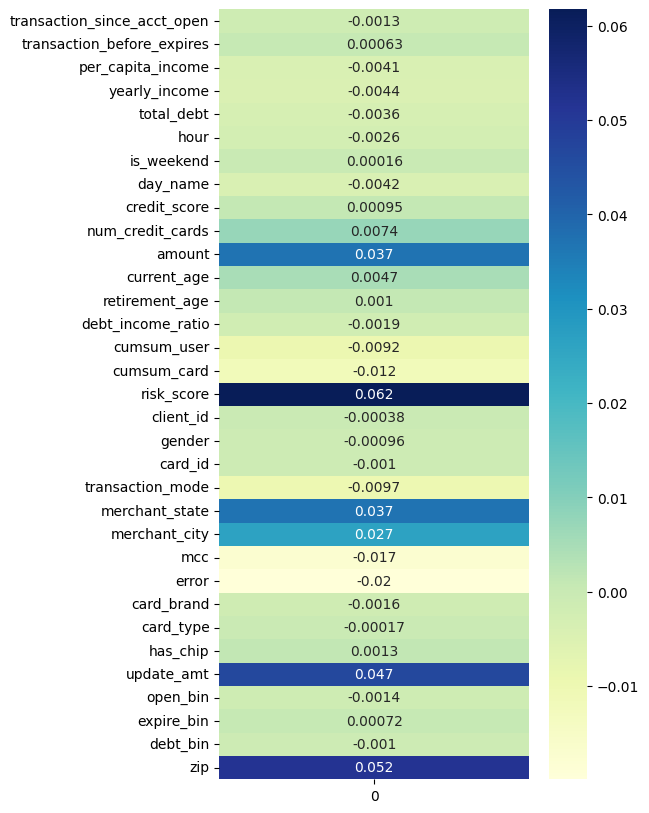

In [108]:

co_mtx = final_df[['transaction_since_acct_open','transaction_before_expires','per_capita_income','yearly_income','total_debt','hour','is_weekend','day_name',
                    'credit_score','num_credit_cards','amount','current_age','retirement_age','debt_income_ratio','cumsum_user','cumsum_card','risk_score',
                'client_id','gender','card_id','transaction_mode','merchant_state','merchant_city','mcc','error','card_brand','card_type','has_chip','update_amt','open_bin','expire_bin','debt_bin','zip']].corrwith(final_df.fraud)

fig, ax = plt.subplots(figsize=(5,10))
sns.heatmap(pd.DataFrame(co_mtx),annot = True,cmap="YlGnBu")
plt.show()

* risk_score, zip, update_amt, merchant_state, and amount are the most influential features in detecting fraud.
* open_bin, card_type, transaction_since_acct_open, and client_id have near-zero influence and could be candidates for removal.
* error, mcc, transaction_mode, and cumsum_card are negatively associated with fraud, suggesting these values may indicate lower risk.

In [109]:
round(co_mtx,3).sort_values()

error                         -0.020
mcc                           -0.017
cumsum_card                   -0.012
transaction_mode              -0.010
cumsum_user                   -0.009
day_name                      -0.004
yearly_income                 -0.004
per_capita_income             -0.004
total_debt                    -0.004
hour                          -0.003
card_brand                    -0.002
debt_income_ratio             -0.002
transaction_since_acct_open   -0.001
card_id                       -0.001
debt_bin                      -0.001
open_bin                      -0.001
gender                        -0.001
card_type                     -0.000
is_weekend                     0.000
client_id                     -0.000
credit_score                   0.001
transaction_before_expires     0.001
expire_bin                     0.001
retirement_age                 0.001
has_chip                       0.001
current_age                    0.005
num_credit_cards               0.007
m

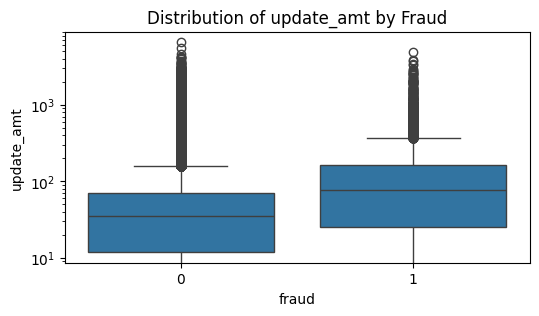

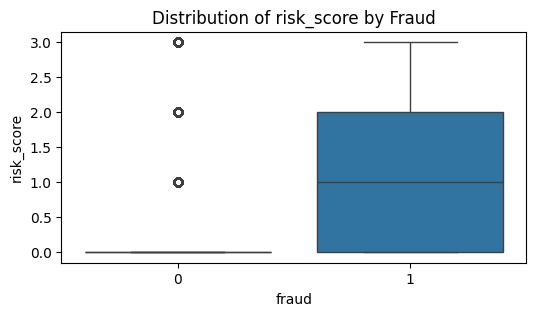

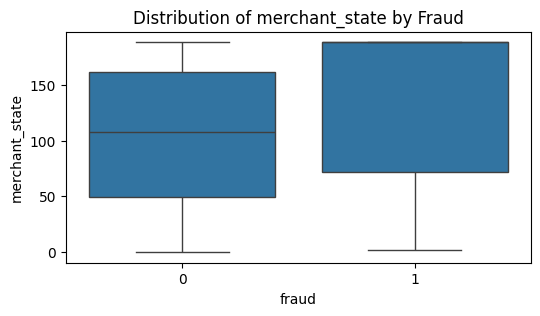

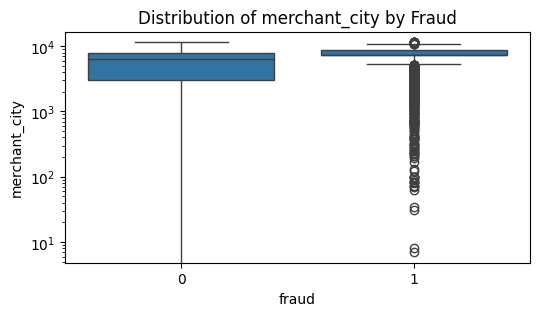

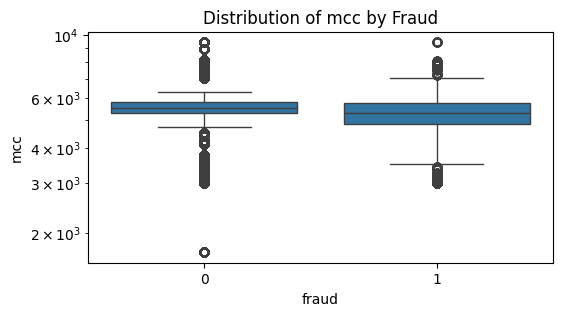

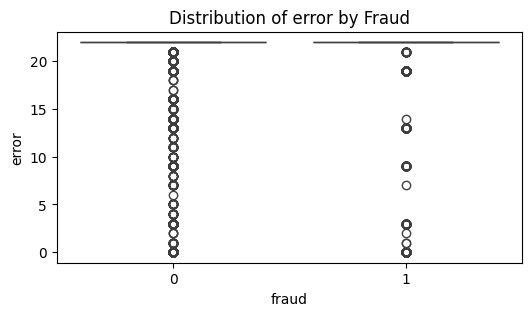

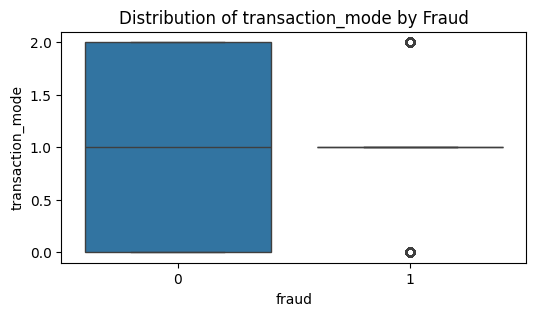

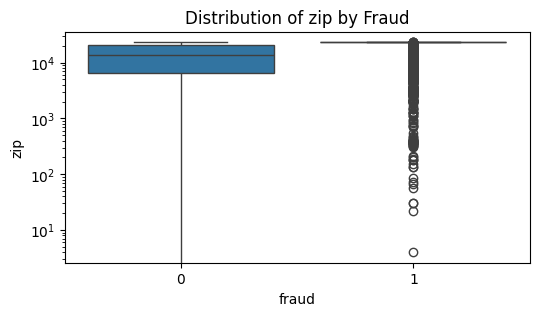

In [110]:
features = ['update_amt', 'risk_score', 'merchant_state', 'merchant_city', 'mcc','error', 'transaction_mode','zip']
for feature in features:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=final_df, x='fraud', y=feature)
    plt.title(f'Distribution of {feature} by Fraud')
    plt.yscale('log') if final_df[feature].max() > 1000 else None
    plt.show()


In [111]:
main_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,transaction_id,fraud,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_year,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,Description,year,month
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,7475327.0,No,Mastercard,Debit (Prepaid),07/2022,YES,2,55.0,05/2008,2008,30,67,1989,7,Female,23679.0,48277.0,110153.0,740,4,Miscellaneous Food Stores,2010,1
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,7475328.0,No,Mastercard,Credit,12/2024,YES,1,9100.0,09/2005,2015,48,67,1971,6,Male,18076.0,36853.0,112139.0,834,5,Department Stores,2010,1
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,7475329.0,No,Mastercard,Debit,05/2020,YES,1,14802.0,01/2006,2008,49,65,1970,4,Male,16894.0,34449.0,36540.0,686,3,Money Transfer,2010,1
3,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None,NaN,NaN,Mastercard,Debit,10/2024,NO,2,37634.0,05/2004,2006,52,67,1967,5,Female,26168.0,53350.0,128676.0,685,5,Money Transfer,2010,1
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,7475332.0,No,Visa,Debit,01/2020,YES,1,19113.0,07/2009,2014,51,69,1968,5,Male,33529.0,68362.0,96182.0,711,2,Drinking Places (Alcoholic Beverages),2010,1


In [112]:
columns = ['amount', 'merchant_state', 'merchant_city', 'mcc','error', 'transaction_mode','zip','card_id','has_chip','card_type','card_brand','fraud']

In [113]:
main_df = main_df[columns]